In [1]:
from __future__ import print_function, division
%matplotlib inline


import os
resultDir = "../results/"
os.chdir(resultDir)

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

In [2]:
import numpy as np
import modisco
import theano
print("Theano version:",theano.__version__)
import sys
print (sys.version)

Theano version: 1.0.2
2.7.15 |Anaconda, Inc.| (default, May  1 2018, 23:32:55) 
[GCC 7.2.0]


Using cuDNN version 7001 on context None
Mapped name None to device cuda0: GeForce GTX TITAN X (0000:08:00.0)


### Functions for one-hot encoding sequences

In [3]:
def one_hot_encode_along_channel_axis(sequence):
    #theano dim ordering, uses row axis for one-hot
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1

## Prepare the data for input into TF-MoDISCo

You need a numpy array of importance scores and hypothetical importance scores for every task.

In [4]:
num_tasks = 5

# onehot_data is the one hot encoding of the input sequences used
onehot_data = np.array([one_hot_encode_along_channel_axis(x.rstrip()) 
                        for x in open("../results/sequences.txt")])
                        # generated during preprocessing


# locations of deeplift scores
scores_loc = []
for i in range(num_tasks):
    temp_loc = "../results/scores/rescale_conv_revealcancel_fc_multiref_10_task_" +\
                str(i) + ".npy"
    print(temp_loc)
    scores_loc.append(temp_loc)

# scores & their one-hot encodings
orig_scores = {}
task_to_scores = {}
for i in range(num_tasks):
    orig_scores['task'+str(i)] = np.load(scores_loc[i])
    task_to_scores['task'+str(i)] = onehot_data * np.load(scores_loc[i])[:, :, None]

../results/scores/rescale_conv_revealcancel_fc_multiref_10_task_0.npy
../results/scores/rescale_conv_revealcancel_fc_multiref_10_task_1.npy
../results/scores/rescale_conv_revealcancel_fc_multiref_10_task_2.npy
../results/scores/rescale_conv_revealcancel_fc_multiref_10_task_3.npy
../results/scores/rescale_conv_revealcancel_fc_multiref_10_task_4.npy


Double check by plotting

In [5]:
print("shape of onehot", onehot_data.shape)
print("shape of orig_score",  orig_scores['task0'].shape)
print("shape of score",  task_to_scores['task0'].shape)


scores = task_to_scores
#scores_for_idx_print = original_onehot*scores_for_idx[:,None]
print(onehot_data[0][:10])
print("orig_scores")
print(orig_scores["task0"][0][:10])
print("scores")
print(task_to_scores["task0"][0][:10])

shape of onehot (31433, 1000, 4)
shape of orig_score (31433, 1000)
shape of score (31433, 1000, 4)
[[0 0 1 0]
 [0 0 0 1]
 [0 1 0 0]
 [0 0 0 1]
 [0 1 0 0]
 [0 0 0 1]
 [1 0 0 0]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]]
orig_scores
[ 0.0000000e+00  6.7267545e-05 -1.0612791e-04 -7.5404809e-05
  5.3114898e-05 -9.7926636e-04 -1.9723942e-05 -1.1795012e-03
 -1.9165097e-03 -1.3497125e-03]
scores
[[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  6.7267545e-05]
 [-0.0000000e+00 -1.0612791e-04 -0.0000000e+00 -0.0000000e+00]
 [-0.0000000e+00 -0.0000000e+00 -0.0000000e+00 -7.5404809e-05]
 [ 0.0000000e+00  5.3114898e-05  0.0000000e+00  0.0000000e+00]
 [-0.0000000e+00 -0.0000000e+00 -0.0000000e+00 -9.7926636e-04]
 [-1.9723942e-05 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00]
 [-0.0000000e+00 -0.0000000e+00 -0.0000000e+00 -1.1795012e-03]
 [-0.0000000e+00 -0.0000000e+00 -0.0000000e+00 -1.9165097e-03]
 [-0.0000000e+00 -0.0000000e+00 -0.0000000e+00 -1.

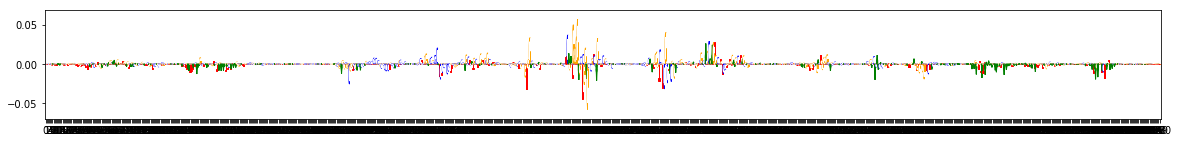

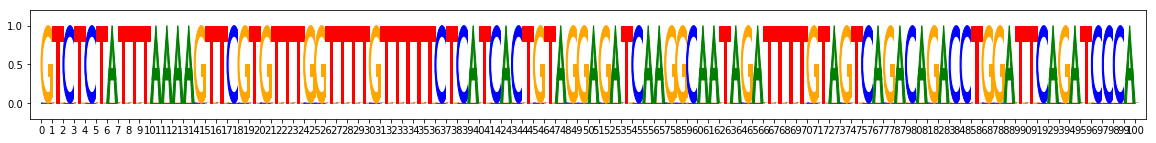

In [6]:
import modisco.visualization
from modisco.visualization import viz_sequence

#viz_sequence.plot_weights(task_to_scores['task0'][0,:])
#viz_sequence.plot_weights(task_to_hyp_scores['task0'][0,:])

viz_sequence.plot_weights(task_to_scores["task0"][0])
viz_sequence.plot_weights(onehot_data[0][:100])

## Run TF-MoDISco

TF-MoDISco first identifies seqlets, then splits the seqlets into "metaclusters" according to their pattern of activity across all the tasks, and then performs clustering within each task. Since there is just one task, there are only 2 possible metaclusters: +1 for the task and -1 for the task. The -1 metacluster does not turn up any motifs after noise filtering, but the +1 metacluster produces two motifs.

To demonstrate customization, the code below has slight modifications from default settings in the following ways:
- Because the TAL and GATA motifs are relatively short compared to something like CTCF, it uses a sliding window size of 15 (rather than the default of 21) and flanks of 5 (rather than the default of 10). The sliding window size and flanks should be adjusted according to the expected length of the core motif and its flanks. If the window size or flank sizes are too long, you risk picking up more noise.
- During the seqlet clustering, motifs are trimmed to the central `trim_to_window_size` bp with the highest importance. `trim_to_window_size` is set to 10 rather than the default of 30. After the trimming is done, the seqlet is expanded on either side by `initial_flank_to_add`. This is set to 3 rather than the default of 10.
- The `final_min_cluster_size` is set to 60 rather than the default of 30. This is used to filter out small clusters with relatively weak support (in this case, fewer than 50 seqlets).
- It uses kmers of length 5 with 1 gap and no mismatches to compute the "quick and dirty" affinity matrix across all seqlets. The "quick and dirty" affinity matrix is used both for noise filtering and as a first pass to speed up computation of the continuous jaccard affinity matrix (the latter affinities are only computed between seqlets deemed to be close together by the "quick and dirty" method). I made the kmer length smaller to keep memory usage on the GPU down when testing on my macbook pro. The default is to use kmers of length 8 with 3 gaps and 2 mismatches, and this works fine on more modern GPUs than the one in my 4-year-old macbook.

On task task0
Done 0
Done 5000
Done 10000
Done 15000
Done 20000
Done 25000
Done 30000
Done 0
Done 5000
Done 10000
Done 15000
Done 20000
Done 25000
Done 30000
Done 0
Done 5000
Done 10000
Done 15000
Done 20000
Done 25000
Done 30000
Done 0
Done 5000
Done 10000
Done 15000
Done 20000
Done 25000
Done 30000
Done 0
Done 5000
Done 10000
Done 15000
Done 20000
Done 25000
Done 30000
Done 0
Done 5000
Done 10000
Done 15000
Done 20000
Done 25000
Done 30000
Done 0
Done 5000
Done 10000
Done 15000
Done 20000
Done 25000
Done 30000
Done 0
Done 5000
Done 10000
Done 15000
Done 20000
Done 25000
Done 30000
Done 0
Done 5000
Done 10000
Done 15000
Done 20000
Done 25000
Done 30000
Done 0
Done 5000
Done 10000
Done 15000
Done 20000
Done 25000
Done 30000
Done 0
Done 5000
Done 10000
Done 15000
Done 20000
Done 25000
Done 30000
Got 314275 coords
Computing thresholds
Bandwidth calculated: 0.03320687264204025


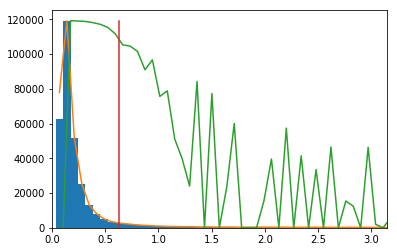

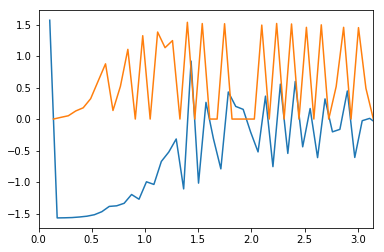

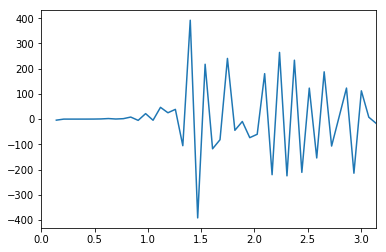

Computed threshold 0.62909384297207
24709 coords remaining after thresholding
Limiting to top 20000
On task task1
Done 0
Done 5000
Done 10000
Done 15000
Done 20000
Done 25000
Done 30000
Done 0
Done 5000
Done 10000
Done 15000
Done 20000
Done 25000
Done 30000
Done 0
Done 5000
Done 10000
Done 15000
Done 20000
Done 25000
Done 30000
Done 0
Done 5000
Done 10000
Done 15000
Done 20000
Done 25000
Done 30000
Done 0
Done 5000
Done 10000
Done 15000
Done 20000
Done 25000
Done 30000
Done 0
Done 5000
Done 10000
Done 15000
Done 20000
Done 25000
Done 30000
Done 0
Done 5000
Done 10000
Done 15000
Done 20000
Done 25000
Done 30000
Done 0
Done 5000
Done 10000
Done 15000
Done 20000
Done 25000
Done 30000
Done 0
Done 5000
Done 10000
Done 15000
Done 20000
Done 25000
Done 30000
Done 0
Done 5000
Done 10000
Done 15000
Done 20000
Done 25000
Done 30000
Done 0
Done 5000
Done 10000
Done 15000
Done 20000
Done 25000
Done 30000
Got 314074 coords
Computing thresholds
Bandwidth calculated: 0.048444800078868866


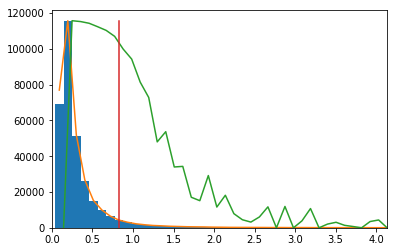

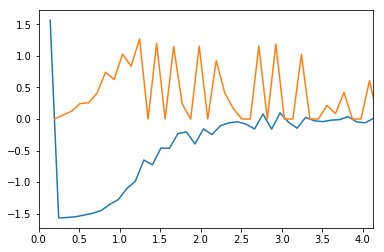

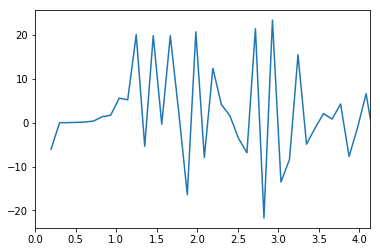

Computed threshold 0.8263228740543127
18092 coords remaining after thresholding
On task task2
Done 0
Done 5000
Done 10000
Done 15000
Done 20000
Done 25000
Done 30000
Done 0
Done 5000
Done 10000
Done 15000
Done 20000
Done 25000
Done 30000
Done 0
Done 5000
Done 10000
Done 15000
Done 20000
Done 25000
Done 30000
Done 0
Done 5000
Done 10000
Done 15000
Done 20000
Done 25000
Done 30000
Done 0
Done 5000
Done 10000
Done 15000
Done 20000
Done 25000
Done 30000
Done 0
Done 5000
Done 10000
Done 15000
Done 20000
Done 25000
Done 30000
Done 0
Done 5000
Done 10000
Done 15000
Done 20000
Done 25000
Done 30000
Done 0
Done 5000
Done 10000
Done 15000
Done 20000
Done 25000
Done 30000
Done 0
Done 5000
Done 10000
Done 15000
Done 20000
Done 25000
Done 30000
Done 0
Done 5000
Done 10000
Done 15000
Done 20000
Done 25000
Done 30000
Done 0
Done 5000
Done 10000
Done 15000
Done 20000
Done 25000
Done 30000
Got 314299 coords
Computing thresholds
Bandwidth calculated: 0.05299052596092224


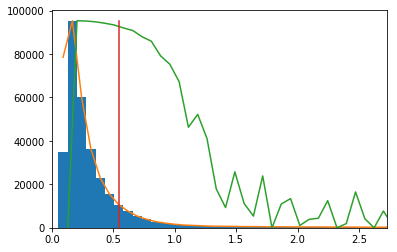

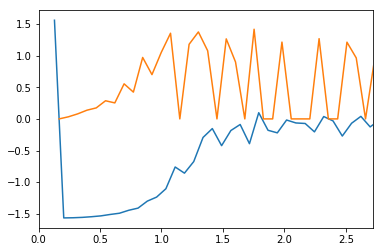

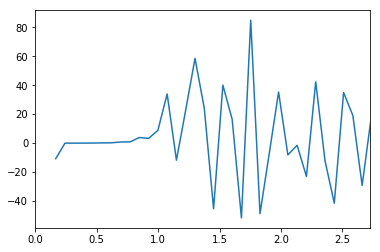

Computed threshold 0.5447665404528379
43492 coords remaining after thresholding
Limiting to top 20000
On task task3
Done 0
Done 5000
Done 10000
Done 15000
Done 20000
Done 25000
Done 30000
Done 0
Done 5000
Done 10000
Done 15000
Done 20000
Done 25000
Done 30000
Done 0
Done 5000
Done 10000
Done 15000
Done 20000
Done 25000
Done 30000
Done 0
Done 5000
Done 10000
Done 15000
Done 20000
Done 25000
Done 30000
Done 0
Done 5000
Done 10000
Done 15000
Done 20000
Done 25000
Done 30000
Done 0
Done 5000
Done 10000
Done 15000
Done 20000
Done 25000
Done 30000
Done 0
Done 5000
Done 10000
Done 15000
Done 20000
Done 25000
Done 30000
Done 0
Done 5000
Done 10000
Done 15000
Done 20000
Done 25000
Done 30000
Done 0
Done 5000
Done 10000
Done 15000
Done 20000
Done 25000
Done 30000
Done 0
Done 5000
Done 10000
Done 15000
Done 20000
Done 25000
Done 30000
Done 0
Done 5000
Done 10000
Done 15000
Done 20000
Done 25000
Done 30000
Got 314218 coords
Computing thresholds
Bandwidth calculated: 0.03941402584314346


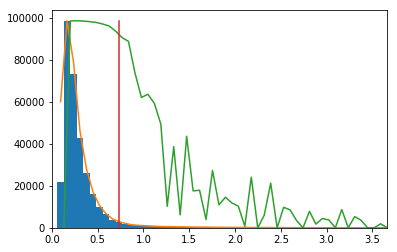

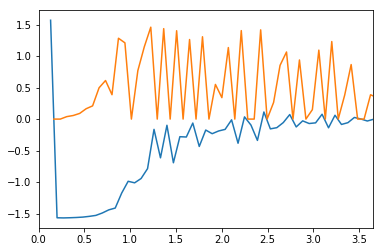

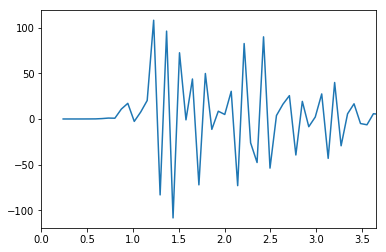

Computed threshold 0.7310417619720101
13885 coords remaining after thresholding
On task task4
Done 0
Done 5000
Done 10000
Done 15000
Done 20000
Done 25000
Done 30000
Done 0
Done 5000
Done 10000
Done 15000
Done 20000
Done 25000
Done 30000
Done 0
Done 5000
Done 10000
Done 15000
Done 20000
Done 25000
Done 30000
Done 0
Done 5000
Done 10000
Done 15000
Done 20000
Done 25000
Done 30000
Done 0
Done 5000
Done 10000
Done 15000
Done 20000
Done 25000
Done 30000
Done 0
Done 5000
Done 10000
Done 15000
Done 20000
Done 25000
Done 30000
Done 0
Done 5000
Done 10000
Done 15000
Done 20000
Done 25000
Done 30000
Done 0
Done 5000
Done 10000
Done 15000
Done 20000
Done 25000
Done 30000
Done 0
Done 5000
Done 10000
Done 15000
Done 20000
Done 25000
Done 30000
Done 0
Done 5000
Done 10000
Done 15000
Done 20000
Done 25000
Done 30000
Done 0
Done 5000
Done 10000
Done 15000
Done 20000
Done 25000
Done 30000
Got 313435 coords
Computing thresholds
Bandwidth calculated: 0.03487972915172577


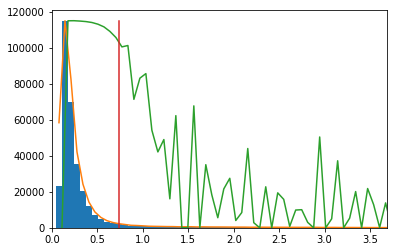

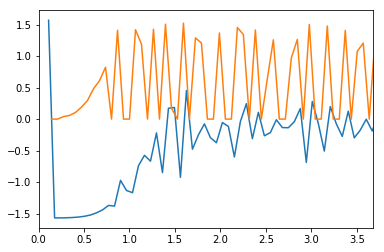

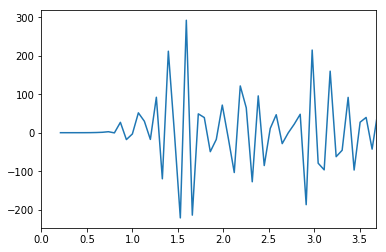

Computed threshold 0.7366811979189516
18645 coords remaining after thresholding
After resolving overlaps, got 32935 seqlets
26 activity patterns with support >= 200 out of 243 possible patterns
Metacluster sizes:  [6246, 3115, 3069, 3058, 2778, 1045, 939, 846, 838, 807, 788, 708, 698, 694, 685, 682, 557, 474, 429, 331, 314, 291, 272, 254, 222, 212]
Idx to activities:  {0: '1,1,1,1,1', 1: '1,0,1,1,1', 2: '1,-1,1,0,1', 3: '1,0,1,0,1', 4: '0,1,0,0,0', 5: '1,1,1,0,1', 6: '0,0,-1,-1,0', 7: '0,0,-1,-1,-1', 8: '0,1,-1,0,0', 9: '1,0,0,0,0', 10: '-1,1,-1,-1,-1', 11: '0,1,0,1,0', 12: '0,1,0,1,1', 13: '0,1,-1,-1,-1', 14: '1,0,0,0,1', 15: '0,1,-1,-1,0', 16: '1,-1,0,-1,0', 17: '1,1,0,1,1', 18: '-1,1,0,0,0', 19: '0,1,1,1,1', 20: '1,1,0,0,1', 21: '1,0,0,-1,0', 22: '0,0,1,1,1', 23: '1,0,1,-1,1', 24: '-1,1,-1,0,-1', 25: '0,0,-1,0,0'}
On metacluster 25
Metacluster size 212
Relevant tasks:  ('task2',)
Relevant signs:  (-1,)
(Round 1) num seqlets: 212
(Round 1) Computing coarse affmat
Beginning embedding 

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.7s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    4.3s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    5.3s finished


Louvain completed 200 runs in 9.21875500679 seconds
Wrote graph to binary file in 0.0181610584259 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.741478
Louvain completed 51 runs in 19.0765750408 seconds
Preproc + Louvain took 28.3613169193 s
Got 6 clusters after round 1
Counts:
{0: 49, 1: 43, 2: 37, 3: 34, 4: 20, 5: 18}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 49 seqlets
Trimmed 7 out of 49
Aggregating for cluster 1 with 43 seqlets
Trimmed 12 out of 43
Aggregating for cluster 2 with 37 seqlets
Trimmed 0 out of 37
Aggregating for cluster 3 with 34 seqlets
Trimmed 2 out of 34
Aggregating for cluster 4 with 20 seqlets
Trimmed 3 out of 20
Aggregating for cluster 5 with 18 seqlets
Trimmed 0 out of 18
(Round 2) num seqlets: 177
(Round 2) Computing coarse affmat
Beginning embedding computation
Computing embeddings
Finished embedding computation in 0.03 s
Starting affinity matrix computations
Normalization computed 

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    4.4s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    5.4s finished


Louvain completed 200 runs in 9.30087685585 seconds
Wrote graph to binary file in 0.0216100215912 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.741805
Louvain completed 51 runs in 18.9528000355 seconds
Preproc + Louvain took 28.3134799004 s
Got 6 clusters after round 2
Counts:
{0: 42, 1: 40, 2: 35, 3: 26, 4: 20, 5: 14}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 42 seqlets
Trimmed 0 out of 42
Aggregating for cluster 1 with 40 seqlets
Trimmed 3 out of 40
Aggregating for cluster 2 with 35 seqlets
Trimmed 5 out of 35
Aggregating for cluster 3 with 26 seqlets
Trimmed 2 out of 26
Aggregating for cluster 4 with 20 seqlets
Trimmed 3 out of 20
Aggregating for cluster 5 with 14 seqlets
Trimmed 2 out of 14
Got 6 clusters
Splitting into subclusters...
Merging on 6 clusters
On merging iteration 1
Computing pattern to seqlet distances
Computing pattern to pattern distances
Got 6 patterns after merging
Performing seqlet rea

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    4.4s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    5.4s finished


Louvain completed 200 runs in 10.2094559669 seconds
Wrote graph to binary file in 0.0421779155731 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.76425
Louvain completed 51 runs in 19.7472732067 seconds
Preproc + Louvain took 30.0499989986 s
Got 8 clusters after round 1
Counts:
{0: 49, 1: 36, 2: 33, 3: 30, 4: 29, 5: 19, 6: 12, 7: 11}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 49 seqlets
Trimmed 3 out of 49
Aggregating for cluster 1 with 36 seqlets
Trimmed 1 out of 36
Aggregating for cluster 2 with 33 seqlets
Trimmed 3 out of 33
Aggregating for cluster 3 with 30 seqlets
Trimmed 7 out of 30
Aggregating for cluster 4 with 29 seqlets
Trimmed 2 out of 29
Aggregating for cluster 5 with 19 seqlets
Trimmed 0 out of 19
Aggregating for cluster 6 with 12 seqlets
Trimmed 0 out of 12
Aggregating for cluster 7 with 11 seqlets
Trimmed 4 out of 11
(Round 2) num seqlets: 199
(Round 2) Computing coarse affmat
Beginning embedding

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    4.4s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    5.4s finished


Louvain completed 200 runs in 9.36670613289 seconds
Wrote graph to binary file in 0.0299451351166 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.696136
After 4 runs, maximum modularity is Q = 0.697399
Louvain completed 54 runs in 19.6174759865 seconds
Preproc + Louvain took 29.070704937 s
Got 7 clusters after round 2
Counts:
{0: 50, 1: 37, 2: 34, 3: 31, 4: 19, 5: 18, 6: 10}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 50 seqlets
Trimmed 0 out of 50
Aggregating for cluster 1 with 37 seqlets
Trimmed 0 out of 37
Aggregating for cluster 2 with 34 seqlets
Trimmed 0 out of 34
Aggregating for cluster 3 with 31 seqlets
Trimmed 0 out of 31
Aggregating for cluster 4 with 19 seqlets
Trimmed 0 out of 19
Aggregating for cluster 5 with 18 seqlets
Trimmed 0 out of 18
Aggregating for cluster 6 with 10 seqlets
Trimmed 0 out of 10
Got 7 clusters
Splitting into subclusters...
Merging on 7 clusters
On merging iteration 1
Computing 

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    4.3s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    5.3s finished


Louvain completed 200 runs in 9.25435686111 seconds
Wrote graph to binary file in 0.021644115448 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.777828
After 2 runs, maximum modularity is Q = 0.790982
Louvain completed 52 runs in 19.9109930992 seconds
Preproc + Louvain took 29.2403140068 s
Got 9 clusters after round 1
Counts:
{0: 39, 1: 37, 2: 36, 3: 34, 4: 27, 5: 27, 6: 22, 7: 19, 8: 13}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 39 seqlets
Trimmed 6 out of 39
Aggregating for cluster 1 with 37 seqlets
Trimmed 1 out of 37
Aggregating for cluster 2 with 36 seqlets
Trimmed 1 out of 36
Aggregating for cluster 3 with 34 seqlets
Trimmed 1 out of 34
Aggregating for cluster 4 with 27 seqlets
Trimmed 4 out of 27
Aggregating for cluster 5 with 27 seqlets
Trimmed 2 out of 27
Aggregating for cluster 6 with 22 seqlets
Trimmed 1 out of 22
Aggregating for cluster 7 with 19 seqlets
Trimmed 0 out of 19
Aggregating for cluster 

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    4.3s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    5.3s finished


Louvain completed 200 runs in 9.45352888107 seconds
Wrote graph to binary file in 0.0362150669098 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.705673
After 4 runs, maximum modularity is Q = 0.712326
After 6 runs, maximum modularity is Q = 0.715797
After 21 runs, maximum modularity is Q = 0.722668
After 48 runs, maximum modularity is Q = 0.723915
Louvain completed 98 runs in 36.8037149906 seconds
Preproc + Louvain took 46.3483650684 s
Got 10 clusters after round 2
Counts:
{0: 45, 1: 34, 2: 33, 3: 24, 4: 23, 5: 21, 6: 20, 7: 14, 8: 14, 9: 9}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 45 seqlets
Trimmed 0 out of 45
Aggregating for cluster 1 with 34 seqlets
Trimmed 0 out of 34
Aggregating for cluster 2 with 33 seqlets
Trimmed 1 out of 33
Aggregating for cluster 3 with 24 seqlets
Trimmed 0 out of 24
Aggregating for cluster 4 with 23 seqlets
Trimmed 0 out of 23
Aggregating for cluster 5 with 21 seqlets
Trimmed 2 o

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    4.4s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    5.3s finished


Louvain completed 200 runs in 9.50982904434 seconds
Wrote graph to binary file in 0.0335772037506 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.580095
Louvain completed 51 runs in 18.6701180935 seconds
Preproc + Louvain took 28.2631709576 s
Got 7 clusters after round 1
Counts:
{0: 81, 1: 40, 2: 32, 3: 29, 4: 18, 5: 16, 6: 16}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 81 seqlets
Trimmed 6 out of 81
Aggregating for cluster 1 with 40 seqlets
Trimmed 9 out of 40
Aggregating for cluster 2 with 32 seqlets
Trimmed 2 out of 32
Aggregating for cluster 3 with 29 seqlets
Trimmed 1 out of 29
Aggregating for cluster 4 with 18 seqlets
Trimmed 0 out of 18
Aggregating for cluster 5 with 16 seqlets
Trimmed 0 out of 16
Aggregating for cluster 6 with 16 seqlets
Trimmed 0 out of 16
(Round 2) num seqlets: 214
(Round 2) Computing coarse affmat
Beginning embedding computation
Computing embeddings
Finished embedding computation in 

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    4.4s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    5.5s finished


Louvain completed 200 runs in 10.115655899 seconds
Wrote graph to binary file in 0.0243649482727 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.740087
Louvain completed 51 runs in 19.5965981483 seconds
Preproc + Louvain took 29.8517448902 s
Got 9 clusters after round 2
Counts:
{0: 43, 1: 38, 2: 36, 3: 29, 4: 18, 5: 16, 6: 15, 7: 13, 8: 6}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 43 seqlets
Trimmed 5 out of 43
Aggregating for cluster 1 with 38 seqlets
Trimmed 1 out of 38
Aggregating for cluster 2 with 36 seqlets
Trimmed 1 out of 36
Aggregating for cluster 3 with 29 seqlets
Trimmed 3 out of 29
Aggregating for cluster 4 with 18 seqlets
Trimmed 2 out of 18
Aggregating for cluster 5 with 16 seqlets
Trimmed 0 out of 16
Aggregating for cluster 6 with 15 seqlets
Trimmed 2 out of 15
Aggregating for cluster 7 with 13 seqlets
Trimmed 3 out of 13
Aggregating for cluster 8 with 6 seqlets
Trimmed 0 out of 6
Got 9 clusters

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.7s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    4.5s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    5.5s finished


Louvain completed 200 runs in 9.82585597038 seconds
Wrote graph to binary file in 0.0385539531708 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.807543
Louvain completed 51 runs in 18.7245078087 seconds
Preproc + Louvain took 28.6607310772 s
Got 9 clusters after round 1
Counts:
{0: 48, 1: 38, 2: 37, 3: 37, 4: 28, 5: 26, 6: 24, 7: 24, 8: 21}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 48 seqlets
Trimmed 2 out of 48
Aggregating for cluster 1 with 38 seqlets
Trimmed 1 out of 38
Aggregating for cluster 2 with 37 seqlets
Trimmed 6 out of 37
Aggregating for cluster 3 with 37 seqlets
Trimmed 1 out of 37
Aggregating for cluster 4 with 28 seqlets
Trimmed 3 out of 28
Aggregating for cluster 5 with 26 seqlets
Trimmed 2 out of 26
Aggregating for cluster 6 with 24 seqlets
Trimmed 0 out of 24
Aggregating for cluster 7 with 24 seqlets
Trimmed 2 out of 24
Aggregating for cluster 8 with 21 seqlets
Trimmed 0 out of 21
(Round 2) 

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    4.2s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    5.4s finished


Louvain completed 200 runs in 9.81859993935 seconds
Wrote graph to binary file in 0.0572619438171 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.730072
After 2 runs, maximum modularity is Q = 0.753929
After 4 runs, maximum modularity is Q = 0.753938
After 8 runs, maximum modularity is Q = 0.754233
Louvain completed 58 runs in 21.9806950092 seconds
Preproc + Louvain took 31.9340250492 s
Got 9 clusters after round 2
Counts:
{0: 57, 1: 41, 2: 36, 3: 36, 4: 35, 5: 23, 6: 18, 7: 13, 8: 7}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 57 seqlets
Trimmed 0 out of 57
Aggregating for cluster 1 with 41 seqlets
Trimmed 2 out of 41
Aggregating for cluster 2 with 36 seqlets
Trimmed 4 out of 36
Aggregating for cluster 3 with 36 seqlets
Trimmed 4 out of 36
Aggregating for cluster 4 with 35 seqlets
Trimmed 5 out of 35
Aggregating for cluster 5 with 23 seqlets
Trimmed 0 out of 23
Aggregating for cluster 6 with 18 seqlets
Trimmed 

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    4.4s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    5.4s finished


Louvain completed 200 runs in 9.50150108337 seconds
Wrote graph to binary file in 0.0344929695129 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.668601
Louvain completed 51 runs in 18.8063001633 seconds
Preproc + Louvain took 28.3856348991 s
Got 5 clusters after round 1
Counts:
{0: 93, 1: 69, 2: 48, 3: 25, 4: 20}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 93 seqlets
Trimmed 5 out of 93
Aggregating for cluster 1 with 69 seqlets
Trimmed 16 out of 69
Aggregating for cluster 2 with 48 seqlets
Trimmed 6 out of 48
Aggregating for cluster 3 with 25 seqlets
Trimmed 3 out of 25
Aggregating for cluster 4 with 20 seqlets
Trimmed 2 out of 20
(Round 2) num seqlets: 223
(Round 2) Computing coarse affmat
Beginning embedding computation
Computing embeddings
Finished embedding computation in 0.05 s
Starting affinity matrix computations
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.0 s
Normalization comput

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.5s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    4.4s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    5.5s finished


Louvain completed 200 runs in 9.4808909893 seconds
Wrote graph to binary file in 0.044764995575 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.69767
After 3 runs, maximum modularity is Q = 0.697995
Louvain completed 53 runs in 20.0290360451 seconds
Preproc + Louvain took 29.6014530659 s
Got 6 clusters after round 2
Counts:
{0: 58, 1: 57, 2: 32, 3: 31, 4: 30, 5: 15}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 58 seqlets
Trimmed 0 out of 58
Aggregating for cluster 1 with 57 seqlets
Trimmed 0 out of 57
Aggregating for cluster 2 with 32 seqlets
Trimmed 0 out of 32
Aggregating for cluster 3 with 31 seqlets
Trimmed 1 out of 31
Aggregating for cluster 4 with 30 seqlets
Trimmed 6 out of 30
Aggregating for cluster 5 with 15 seqlets
Trimmed 1 out of 15
Got 6 clusters
Splitting into subclusters...
Merging on 6 clusters
On merging iteration 1
Computing pattern to seqlet distances
Computing pattern to pattern distances
Coll

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.7s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    4.4s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    5.4s finished


Louvain completed 200 runs in 9.33219695091 seconds
Wrote graph to binary file in 0.0471088886261 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.676655
Louvain completed 51 runs in 18.8928258419 seconds
Preproc + Louvain took 28.333823204 s
Got 8 clusters after round 1
Counts:
{0: 90, 1: 66, 2: 43, 3: 41, 4: 41, 5: 10, 6: 10, 7: 6}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 90 seqlets
Trimmed 3 out of 90
Aggregating for cluster 1 with 66 seqlets
Trimmed 2 out of 66
Aggregating for cluster 2 with 43 seqlets
Trimmed 0 out of 43
Aggregating for cluster 3 with 41 seqlets
Trimmed 5 out of 41
Aggregating for cluster 4 with 41 seqlets
Trimmed 1 out of 41
Aggregating for cluster 5 with 10 seqlets
Trimmed 0 out of 10
Aggregating for cluster 6 with 10 seqlets
Trimmed 0 out of 10
Aggregating for cluster 7 with 6 seqlets
Trimmed 0 out of 6
(Round 2) num seqlets: 284
(Round 2) Computing coarse affmat
Beginning embedding co

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    4.5s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    5.4s finished


Louvain completed 200 runs in 9.78191804886 seconds
Wrote graph to binary file in 0.0314090251923 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.790308
Louvain completed 51 runs in 18.9384281635 seconds
Preproc + Louvain took 28.8308329582 s
Got 8 clusters after round 2
Counts:
{0: 50, 1: 46, 2: 45, 3: 44, 4: 36, 5: 34, 6: 23, 7: 6}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 50 seqlets
Trimmed 2 out of 50
Aggregating for cluster 1 with 46 seqlets
Trimmed 1 out of 46
Aggregating for cluster 2 with 45 seqlets
Trimmed 4 out of 45
Aggregating for cluster 3 with 44 seqlets
Trimmed 3 out of 44
Aggregating for cluster 4 with 36 seqlets
Trimmed 7 out of 36
Aggregating for cluster 5 with 34 seqlets
Trimmed 1 out of 34
Aggregating for cluster 6 with 23 seqlets
Trimmed 0 out of 23
Aggregating for cluster 7 with 6 seqlets
Trimmed 0 out of 6
Got 8 clusters
Splitting into subclusters...
Merging on 8 clusters
On merging iter

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    4.4s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    5.4s finished


Louvain completed 200 runs in 9.6409471035 seconds
Wrote graph to binary file in 0.0853939056396 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.723726
Louvain completed 51 runs in 18.9332950115 seconds
Preproc + Louvain took 28.7474730015 s
Got 7 clusters after round 1
Counts:
{0: 102, 1: 93, 2: 71, 3: 65, 4: 31, 5: 27, 6: 3}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 102 seqlets
Trimmed 13 out of 102
Aggregating for cluster 1 with 93 seqlets
Trimmed 16 out of 93
Aggregating for cluster 2 with 71 seqlets
Trimmed 9 out of 71
Aggregating for cluster 3 with 65 seqlets
Trimmed 8 out of 65
Aggregating for cluster 4 with 31 seqlets
Trimmed 6 out of 31
Aggregating for cluster 5 with 27 seqlets
Trimmed 2 out of 27
Aggregating for cluster 6 with 3 seqlets
Trimmed 0 out of 3
(Round 2) num seqlets: 338
(Round 2) Computing coarse affmat
Beginning embedding computation
Computing embeddings
Finished embedding computation in

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    4.6s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    5.5s finished


Louvain completed 200 runs in 9.76588487625 seconds
Wrote graph to binary file in 0.0573120117188 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.724333
Louvain completed 51 runs in 18.1591570377 seconds
Preproc + Louvain took 28.0661239624 s
Got 6 clusters after round 2
Counts:
{0: 83, 1: 80, 2: 62, 3: 61, 4: 27, 5: 25}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 83 seqlets
Trimmed 7 out of 83
Aggregating for cluster 1 with 80 seqlets
Trimmed 2 out of 80
Aggregating for cluster 2 with 62 seqlets
Trimmed 0 out of 62
Aggregating for cluster 3 with 61 seqlets
Trimmed 0 out of 61
Aggregating for cluster 4 with 27 seqlets
Trimmed 1 out of 27
Aggregating for cluster 5 with 25 seqlets
Trimmed 0 out of 25
Got 6 clusters
Splitting into subclusters...
Inspecting for spurious merging
Wrote graph to binary file in 0.0141098499298 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.0033

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.7s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    4.4s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    5.5s finished


Louvain completed 200 runs in 10.0825760365 seconds
Wrote graph to binary file in 0.0918118953705 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.712502
Louvain completed 51 runs in 18.9740788937 seconds
Preproc + Louvain took 29.2782869339 s
Got 13 clusters after round 1
Counts:
{0: 68, 1: 57, 2: 53, 3: 39, 4: 38, 5: 38, 6: 30, 7: 30, 8: 29, 9: 25, 10: 21, 11: 19, 12: 7}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 68 seqlets
Trimmed 2 out of 68
Aggregating for cluster 1 with 57 seqlets
Trimmed 2 out of 57
Aggregating for cluster 2 with 53 seqlets
Trimmed 3 out of 53
Aggregating for cluster 3 with 39 seqlets
Trimmed 7 out of 39
Aggregating for cluster 4 with 38 seqlets
Trimmed 2 out of 38
Aggregating for cluster 5 with 38 seqlets
Trimmed 2 out of 38
Aggregating for cluster 6 with 30 seqlets
Trimmed 0 out of 30
Aggregating for cluster 7 with 30 seqlets
Trimmed 2 out of 30
Aggregating for cluster 8 with 29 seqlets

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    4.4s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    5.5s finished


Louvain completed 200 runs in 10.0975921154 seconds
Wrote graph to binary file in 0.143070936203 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.658985
After 2 runs, maximum modularity is Q = 0.660239
After 4 runs, maximum modularity is Q = 0.661468
After 5 runs, maximum modularity is Q = 0.66742
Louvain completed 55 runs in 21.3429348469 seconds
Preproc + Louvain took 31.6875100136 s
Got 10 clusters after round 2
Counts:
{0: 96, 1: 80, 2: 57, 3: 56, 4: 42, 5: 41, 6: 19, 7: 17, 8: 16, 9: 7}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 96 seqlets
Trimmed 9 out of 96
Aggregating for cluster 1 with 80 seqlets
Trimmed 3 out of 80
Aggregating for cluster 2 with 57 seqlets
Trimmed 13 out of 57
Aggregating for cluster 3 with 56 seqlets
Trimmed 5 out of 56
Aggregating for cluster 4 with 42 seqlets
Trimmed 9 out of 42
Aggregating for cluster 5 with 41 seqlets
Trimmed 8 out of 41
Aggregating for cluster 6 with 19 seqlets
T

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    4.5s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    5.5s finished


Louvain completed 200 runs in 9.90459513664 seconds
Wrote graph to binary file in 0.21147608757 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.721452
After 2 runs, maximum modularity is Q = 0.727864
Louvain completed 52 runs in 18.5984051228 seconds
Preproc + Louvain took 28.8051409721 s
Got 7 clusters after round 1
Counts:
{0: 113, 1: 110, 2: 107, 3: 80, 4: 72, 5: 57, 6: 11}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 113 seqlets
Trimmed 4 out of 113
Aggregating for cluster 1 with 110 seqlets
Trimmed 12 out of 110
Aggregating for cluster 2 with 107 seqlets
Trimmed 2 out of 107
Aggregating for cluster 3 with 80 seqlets
Trimmed 2 out of 80
Aggregating for cluster 4 with 72 seqlets
Trimmed 12 out of 72
Aggregating for cluster 5 with 57 seqlets
Trimmed 11 out of 57
Aggregating for cluster 6 with 11 seqlets
Trimmed 0 out of 11
(Round 2) num seqlets: 507
(Round 2) Computing coarse affmat
Beginning embedding computat

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.5s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    4.4s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    5.6s finished


Louvain completed 200 runs in 9.66467499733 seconds
Wrote graph to binary file in 0.126514196396 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.742479
Louvain completed 51 runs in 17.96833992 seconds
Preproc + Louvain took 27.8564348221 s
Got 7 clusters after round 2
Counts:
{0: 102, 1: 100, 2: 92, 3: 79, 4: 68, 5: 47, 6: 19}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 102 seqlets
Trimmed 1 out of 102
Aggregating for cluster 1 with 100 seqlets
Trimmed 5 out of 100
Aggregating for cluster 2 with 92 seqlets
Trimmed 1 out of 92
Aggregating for cluster 3 with 79 seqlets
Trimmed 6 out of 79
Aggregating for cluster 4 with 68 seqlets
Trimmed 6 out of 68
Aggregating for cluster 5 with 47 seqlets
Trimmed 5 out of 47
Aggregating for cluster 6 with 19 seqlets
Trimmed 0 out of 19
Got 7 clusters
Splitting into subclusters...
Inspecting for spurious merging
Wrote graph to binary file in 0.0201871395111 seconds
Running Louvai

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    4.7s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    5.7s finished


Louvain completed 200 runs in 10.398799181 seconds
Wrote graph to binary file in 0.234102010727 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.763656
After 2 runs, maximum modularity is Q = 0.765514
After 5 runs, maximum modularity is Q = 0.769403
After 11 runs, maximum modularity is Q = 0.770602
After 12 runs, maximum modularity is Q = 0.773769
After 20 runs, maximum modularity is Q = 0.774307
After 47 runs, maximum modularity is Q = 0.775117
Louvain completed 97 runs in 37.0475108624 seconds
Preproc + Louvain took 47.8228051662 s
Got 11 clusters after round 1
Counts:
{0: 122, 1: 111, 2: 85, 3: 77, 4: 76, 5: 55, 6: 46, 7: 28, 8: 16, 9: 11, 10: 8}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 122 seqlets
Trimmed 7 out of 122
Aggregating for cluster 1 with 111 seqlets
Trimmed 9 out of 111
Aggregating for cluster 2 with 85 seqlets
Trimmed 2 out of 85
Aggregating for cluster 3 with 77 seqlets
Trimmed 5 out of 77
Agg

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    4.5s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    5.7s finished


Louvain completed 200 runs in 10.0246398449 seconds
Wrote graph to binary file in 0.180700063705 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.75318
After 2 runs, maximum modularity is Q = 0.753941
After 18 runs, maximum modularity is Q = 0.754643
Louvain completed 68 runs in 24.8457641602 seconds
Preproc + Louvain took 35.1537060738 s
Got 12 clusters after round 2
Counts:
{0: 102, 1: 99, 2: 66, 3: 66, 4: 59, 5: 52, 6: 47, 7: 47, 8: 29, 9: 18, 10: 11, 11: 8}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 102 seqlets
Trimmed 15 out of 102
Aggregating for cluster 1 with 99 seqlets
Trimmed 19 out of 99
Aggregating for cluster 2 with 66 seqlets
Trimmed 19 out of 66
Aggregating for cluster 3 with 66 seqlets
Trimmed 2 out of 66
Aggregating for cluster 4 with 59 seqlets
Trimmed 7 out of 59
Aggregating for cluster 5 with 52 seqlets
Trimmed 10 out of 52
Aggregating for cluster 6 with 47 seqlets
Trimmed 7 out of 47
Aggrega

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    4.4s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    5.5s finished


Louvain completed 200 runs in 9.91265916824 seconds
Wrote graph to binary file in 0.135893106461 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.710755
After 2 runs, maximum modularity is Q = 0.715634
After 5 runs, maximum modularity is Q = 0.731978
After 16 runs, maximum modularity is Q = 0.732623
Louvain completed 66 runs in 25.7604081631 seconds
Preproc + Louvain took 35.9253518581 s
Got 7 clusters after round 1
Counts:
{0: 131, 1: 126, 2: 107, 3: 86, 4: 57, 5: 39, 6: 14}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 131 seqlets
Trimmed 13 out of 131
Aggregating for cluster 1 with 126 seqlets
Trimmed 3 out of 126
Aggregating for cluster 2 with 107 seqlets
Trimmed 13 out of 107
Aggregating for cluster 3 with 86 seqlets
Trimmed 12 out of 86
Aggregating for cluster 4 with 57 seqlets
Trimmed 2 out of 57
Aggregating for cluster 5 with 39 seqlets
Trimmed 6 out of 39
Aggregating for cluster 6 with 14 seqlets
Trimmed 0

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    4.4s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    5.6s finished


Louvain completed 200 runs in 10.5668540001 seconds
Wrote graph to binary file in 0.204247951508 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.705215
After 2 runs, maximum modularity is Q = 0.705276
After 26 runs, maximum modularity is Q = 0.717412
After 30 runs, maximum modularity is Q = 0.717478
Louvain completed 80 runs in 30.8399631977 seconds
Preproc + Louvain took 41.754513979 s
Got 8 clusters after round 2
Counts:
{0: 123, 1: 88, 2: 88, 3: 77, 4: 65, 5: 56, 6: 7, 7: 7}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 123 seqlets
Trimmed 0 out of 123
Aggregating for cluster 1 with 88 seqlets
Trimmed 0 out of 88
Aggregating for cluster 2 with 88 seqlets
Trimmed 1 out of 88
Aggregating for cluster 3 with 77 seqlets
Trimmed 0 out of 77
Aggregating for cluster 4 with 65 seqlets
Trimmed 0 out of 65
Aggregating for cluster 5 with 56 seqlets
Trimmed 0 out of 56
Aggregating for cluster 6 with 7 seqlets
Trimmed 0 out 

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.7s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    4.6s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    5.8s finished


Louvain completed 200 runs in 10.5964028835 seconds
Wrote graph to binary file in 0.177275180817 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.771298
After 2 runs, maximum modularity is Q = 0.771329
After 6 runs, maximum modularity is Q = 0.778218
Louvain completed 56 runs in 21.3870959282 seconds
Preproc + Louvain took 32.3694300652 s
Got 13 clusters after round 1
Counts:
{0: 109, 1: 102, 2: 84, 3: 78, 4: 77, 5: 56, 6: 50, 7: 40, 8: 30, 9: 15, 10: 13, 11: 6, 12: 5}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 109 seqlets
Trimmed 14 out of 109
Aggregating for cluster 1 with 102 seqlets
Trimmed 4 out of 102
Aggregating for cluster 2 with 84 seqlets
Trimmed 4 out of 84
Aggregating for cluster 3 with 78 seqlets
Trimmed 9 out of 78
Aggregating for cluster 4 with 77 seqlets
Trimmed 7 out of 77
Aggregating for cluster 5 with 56 seqlets
Trimmed 5 out of 56
Aggregating for cluster 6 with 50 seqlets
Trimmed 8 out of 50


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.8s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    4.8s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    5.8s finished


Louvain completed 200 runs in 10.6907680035 seconds
Wrote graph to binary file in 0.157950878143 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.760174
After 2 runs, maximum modularity is Q = 0.763429
After 52 runs, maximum modularity is Q = 0.767643
Louvain completed 102 runs in 38.7375380993 seconds
Preproc + Louvain took 49.7316479683 s
Got 12 clusters after round 2
Counts:
{0: 106, 1: 85, 2: 83, 3: 80, 4: 77, 5: 74, 6: 34, 7: 22, 8: 18, 9: 14, 10: 11, 11: 5}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 106 seqlets
Trimmed 17 out of 106
Aggregating for cluster 1 with 85 seqlets
Trimmed 7 out of 85
Aggregating for cluster 2 with 83 seqlets
Trimmed 23 out of 83
Aggregating for cluster 3 with 80 seqlets
Trimmed 7 out of 80
Aggregating for cluster 4 with 77 seqlets
Trimmed 2 out of 77
Aggregating for cluster 5 with 74 seqlets
Trimmed 16 out of 74
Aggregating for cluster 6 with 34 seqlets
Trimmed 3 out of 34
Aggreg

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    4.5s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    5.6s finished


Louvain completed 200 runs in 10.092648983 seconds
Wrote graph to binary file in 0.205139160156 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.661084
After 4 runs, maximum modularity is Q = 0.675844
After 6 runs, maximum modularity is Q = 0.678082
After 12 runs, maximum modularity is Q = 0.694016
After 23 runs, maximum modularity is Q = 0.694628
After 34 runs, maximum modularity is Q = 0.694875
Louvain completed 84 runs in 33.1634070873 seconds
Preproc + Louvain took 43.6138451099 s
Got 13 clusters after round 1
Counts:
{0: 108, 1: 108, 2: 64, 3: 53, 4: 52, 5: 46, 6: 33, 7: 31, 8: 31, 9: 27, 10: 21, 11: 14, 12: 9}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 108 seqlets
Trimmed 8 out of 108
Aggregating for cluster 1 with 108 seqlets
Trimmed 10 out of 108
Aggregating for cluster 2 with 64 seqlets
Trimmed 4 out of 64
Aggregating for cluster 3 with 53 seqlets
Trimmed 0 out of 53
Aggregating for cluster 4 with 52 se

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    4.6s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    5.7s finished


Louvain completed 200 runs in 10.9770841599 seconds
Wrote graph to binary file in 0.175438165665 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.755401
After 5 runs, maximum modularity is Q = 0.757469
After 7 runs, maximum modularity is Q = 0.770215
After 34 runs, maximum modularity is Q = 0.776821
Louvain completed 84 runs in 32.3377211094 seconds
Preproc + Louvain took 43.6355190277 s
Got 12 clusters after round 2
Counts:
{0: 71, 1: 70, 2: 67, 3: 65, 4: 58, 5: 58, 6: 43, 7: 42, 8: 35, 9: 21, 10: 17, 11: 12}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 71 seqlets
Trimmed 27 out of 71
Aggregating for cluster 1 with 70 seqlets
Trimmed 1 out of 70
Aggregating for cluster 2 with 67 seqlets
Trimmed 11 out of 67
Aggregating for cluster 3 with 65 seqlets
Trimmed 21 out of 65
Aggregating for cluster 4 with 58 seqlets
Trimmed 4 out of 58
Aggregating for cluster 5 with 58 seqlets
Trimmed 11 out of 58
Aggregating for clust

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    4.7s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    5.7s finished


Louvain completed 200 runs in 10.3299999237 seconds
Wrote graph to binary file in 0.341612100601 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.684969
After 4 runs, maximum modularity is Q = 0.686858
After 6 runs, maximum modularity is Q = 0.691396
After 8 runs, maximum modularity is Q = 0.701688
After 18 runs, maximum modularity is Q = 0.705138
Louvain completed 68 runs in 27.4978449345 seconds
Preproc + Louvain took 38.3000020981 s
Got 9 clusters after round 1
Counts:
{0: 139, 1: 102, 2: 87, 3: 74, 4: 73, 5: 50, 6: 49, 7: 38, 8: 10}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 139 seqlets
Trimmed 7 out of 139
Aggregating for cluster 1 with 102 seqlets
Trimmed 1 out of 102
Aggregating for cluster 2 with 87 seqlets
Trimmed 18 out of 87
Aggregating for cluster 3 with 74 seqlets
Trimmed 5 out of 74
Aggregating for cluster 4 with 73 seqlets
Trimmed 2 out of 73
Aggregating for cluster 5 with 50 seqlets
Trimmed 4 out

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.7s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    4.6s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    5.7s finished


Louvain completed 200 runs in 10.3948369026 seconds
Wrote graph to binary file in 0.235985994339 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.712789
After 7 runs, maximum modularity is Q = 0.714529
After 10 runs, maximum modularity is Q = 0.719264
After 20 runs, maximum modularity is Q = 0.720138
Louvain completed 70 runs in 26.8742110729 seconds
Preproc + Louvain took 37.6330971718 s
Got 10 clusters after round 2
Counts:
{0: 94, 1: 92, 2: 77, 3: 74, 4: 66, 5: 48, 6: 46, 7: 40, 8: 39, 9: 2}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 94 seqlets
Trimmed 14 out of 94
Aggregating for cluster 1 with 92 seqlets
Trimmed 19 out of 92
Aggregating for cluster 2 with 77 seqlets
Trimmed 6 out of 77
Aggregating for cluster 3 with 74 seqlets
Trimmed 6 out of 74
Aggregating for cluster 4 with 66 seqlets
Trimmed 4 out of 66
Aggregating for cluster 5 with 48 seqlets
Trimmed 3 out of 48
Aggregating for cluster 6 with 46 seqle

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.7s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    4.8s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    5.8s finished


Louvain completed 200 runs in 11.1009931564 seconds
Wrote graph to binary file in 0.283802032471 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.74223
After 3 runs, maximum modularity is Q = 0.744215
Louvain completed 53 runs in 20.7688090801 seconds
Preproc + Louvain took 32.2980179787 s
Got 9 clusters after round 1
Counts:
{0: 169, 1: 126, 2: 126, 3: 87, 4: 66, 5: 53, 6: 34, 7: 29, 8: 25}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 169 seqlets
Trimmed 14 out of 169
Aggregating for cluster 1 with 126 seqlets
Trimmed 8 out of 126
Aggregating for cluster 2 with 126 seqlets
Trimmed 11 out of 126
Aggregating for cluster 3 with 87 seqlets
Trimmed 4 out of 87
Aggregating for cluster 4 with 66 seqlets
Trimmed 9 out of 66
Aggregating for cluster 5 with 53 seqlets
Trimmed 6 out of 53
Aggregating for cluster 6 with 34 seqlets
Trimmed 2 out of 34
Aggregating for cluster 7 with 29 seqlets
Trimmed 0 out of 29
Aggregating fo

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.7s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    4.8s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    6.0s finished


Louvain completed 200 runs in 10.5522859097 seconds
Wrote graph to binary file in 0.24384021759 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.673096
After 3 runs, maximum modularity is Q = 0.678933
After 39 runs, maximum modularity is Q = 0.680691
After 54 runs, maximum modularity is Q = 0.68203
After 68 runs, maximum modularity is Q = 0.682103
Louvain completed 118 runs in 44.0982010365 seconds
Preproc + Louvain took 55.0010108948 s
Got 9 clusters after round 2
Counts:
{0: 119, 1: 116, 2: 86, 3: 79, 4: 63, 5: 62, 6: 46, 7: 39, 8: 31}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 119 seqlets
Trimmed 0 out of 119
Aggregating for cluster 1 with 116 seqlets
Trimmed 1 out of 116
Aggregating for cluster 2 with 86 seqlets
Trimmed 12 out of 86
Aggregating for cluster 3 with 79 seqlets
Trimmed 0 out of 79
Aggregating for cluster 4 with 63 seqlets
Trimmed 2 out of 63
Aggregating for cluster 5 with 62 seqlets
Trimmed 0 ou

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.7s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    4.7s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    5.7s finished


Louvain completed 200 runs in 10.4018399715 seconds
Wrote graph to binary file in 0.167670965195 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.644174
After 5 runs, maximum modularity is Q = 0.651414
After 7 runs, maximum modularity is Q = 0.689789
Louvain completed 57 runs in 22.5476000309 seconds
Preproc + Louvain took 33.2340250015 s
Got 10 clusters after round 1
Counts:
{0: 154, 1: 130, 2: 61, 3: 51, 4: 47, 5: 40, 6: 40, 7: 28, 8: 28, 9: 19}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 154 seqlets
Trimmed 12 out of 154
Aggregating for cluster 1 with 130 seqlets
Trimmed 13 out of 130
Aggregating for cluster 2 with 61 seqlets
Trimmed 11 out of 61
Aggregating for cluster 3 with 51 seqlets
Trimmed 3 out of 51
Aggregating for cluster 4 with 47 seqlets
Trimmed 9 out of 47
Aggregating for cluster 5 with 40 seqlets
Trimmed 3 out of 40
Aggregating for cluster 6 with 40 seqlets
Trimmed 1 out of 40
Aggregating for clus

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    4.7s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    5.8s finished


Louvain completed 200 runs in 10.6242527962 seconds
Wrote graph to binary file in 0.186611175537 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.739768
After 49 runs, maximum modularity is Q = 0.745884
Louvain completed 99 runs in 36.7475209236 seconds
Preproc + Louvain took 47.6739461422 s
Got 7 clusters after round 2
Counts:
{0: 124, 1: 94, 2: 89, 3: 85, 4: 65, 5: 62, 6: 23}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 124 seqlets
Trimmed 12 out of 124
Aggregating for cluster 1 with 94 seqlets
Trimmed 0 out of 94
Aggregating for cluster 2 with 89 seqlets
Trimmed 0 out of 89
Aggregating for cluster 3 with 85 seqlets
Trimmed 4 out of 85
Aggregating for cluster 4 with 65 seqlets
Trimmed 0 out of 65
Aggregating for cluster 5 with 62 seqlets
Trimmed 0 out of 62
Aggregating for cluster 6 with 23 seqlets
Trimmed 0 out of 23
Got 7 clusters
Splitting into subclusters...
Inspecting for spurious merging
Wrote graph to bin

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.8s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    4.9s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    6.0s finished


Louvain completed 200 runs in 11.2169640064 seconds
Wrote graph to binary file in 0.260566949844 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.80668
Louvain completed 51 runs in 18.9081189632 seconds
Preproc + Louvain took 30.5152142048 s
Got 11 clusters after round 1
Counts:
{0: 146, 1: 115, 2: 72, 3: 71, 4: 71, 5: 64, 6: 61, 7: 47, 8: 45, 9: 34, 10: 33}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 146 seqlets
Trimmed 5 out of 146
Aggregating for cluster 1 with 115 seqlets
Trimmed 6 out of 115
Aggregating for cluster 2 with 72 seqlets
Trimmed 4 out of 72
Aggregating for cluster 3 with 71 seqlets
Trimmed 4 out of 71
Aggregating for cluster 4 with 71 seqlets
Trimmed 7 out of 71
Aggregating for cluster 5 with 64 seqlets
Trimmed 3 out of 64
Aggregating for cluster 6 with 61 seqlets
Trimmed 1 out of 61
Aggregating for cluster 7 with 47 seqlets
Trimmed 2 out of 47
Aggregating for cluster 8 with 45 seqlets
Trimmed 3 

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    4.7s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    5.7s finished


Louvain completed 200 runs in 10.7097878456 seconds
Wrote graph to binary file in 0.213820934296 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.834353
Louvain completed 51 runs in 19.82833004 seconds
Preproc + Louvain took 30.9129531384 s
Got 14 clusters after round 2
Counts:
{0: 84, 1: 74, 2: 69, 3: 69, 4: 68, 5: 62, 6: 54, 7: 51, 8: 38, 9: 36, 10: 34, 11: 33, 12: 31, 13: 20}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 84 seqlets
Trimmed 12 out of 84
Aggregating for cluster 1 with 74 seqlets
Trimmed 15 out of 74
Aggregating for cluster 2 with 69 seqlets
Trimmed 18 out of 69
Aggregating for cluster 3 with 69 seqlets
Trimmed 18 out of 69
Aggregating for cluster 4 with 68 seqlets
Trimmed 11 out of 68
Aggregating for cluster 5 with 62 seqlets
Trimmed 10 out of 62
Aggregating for cluster 6 with 54 seqlets
Trimmed 8 out of 54
Aggregating for cluster 7 with 51 seqlets
Trimmed 14 out of 51
Aggregating for cluster 8 wi

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    4.7s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    5.9s finished


Louvain completed 200 runs in 10.8905689716 seconds
Wrote graph to binary file in 0.356467008591 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.710584
After 19 runs, maximum modularity is Q = 0.718681
After 43 runs, maximum modularity is Q = 0.720809
Louvain completed 93 runs in 34.954308033 seconds
Preproc + Louvain took 46.3337500095 s
Got 7 clusters after round 1
Counts:
{0: 154, 1: 142, 2: 121, 3: 106, 4: 100, 5: 78, 6: 50}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 154 seqlets
Trimmed 15 out of 154
Aggregating for cluster 1 with 142 seqlets
Trimmed 13 out of 142
Aggregating for cluster 2 with 121 seqlets
Trimmed 4 out of 121
Aggregating for cluster 3 with 106 seqlets
Trimmed 9 out of 106
Aggregating for cluster 4 with 100 seqlets
Trimmed 7 out of 100
Aggregating for cluster 5 with 78 seqlets
Trimmed 6 out of 78
Aggregating for cluster 6 with 50 seqlets
Trimmed 5 out of 50
(Round 2) num seqlets: 692
(Round

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.7s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    5.0s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    6.1s finished


Louvain completed 200 runs in 11.3167231083 seconds
Wrote graph to binary file in 0.354249000549 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.740683
After 50 runs, maximum modularity is Q = 0.742681
Louvain completed 100 runs in 37.694865942 seconds
Preproc + Louvain took 49.5166990757 s
Got 6 clusters after round 2
Counts:
{0: 176, 1: 137, 2: 114, 3: 101, 4: 91, 5: 73}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 176 seqlets
Trimmed 18 out of 176
Aggregating for cluster 1 with 137 seqlets
Trimmed 32 out of 137
Aggregating for cluster 2 with 114 seqlets
Trimmed 34 out of 114
Aggregating for cluster 3 with 101 seqlets
Trimmed 11 out of 101
Aggregating for cluster 4 with 91 seqlets
Trimmed 14 out of 91
Aggregating for cluster 5 with 73 seqlets
Trimmed 6 out of 73
Got 6 clusters
Splitting into subclusters...
Inspecting for spurious merging
Wrote graph to binary file in 0.0483901500702 seconds
Running Louvain modu

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.7s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    4.9s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    6.0s finished


Louvain completed 200 runs in 11.096501112 seconds
Wrote graph to binary file in 0.446811914444 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.633896
After 2 runs, maximum modularity is Q = 0.634888
After 4 runs, maximum modularity is Q = 0.639733
After 9 runs, maximum modularity is Q = 0.651077
After 13 runs, maximum modularity is Q = 0.653099
After 16 runs, maximum modularity is Q = 0.657773
Louvain completed 66 runs in 27.3490819931 seconds
Preproc + Louvain took 39.0567660332 s
Got 9 clusters after round 1
Counts:
{0: 189, 1: 124, 2: 113, 3: 110, 4: 93, 5: 79, 6: 69, 7: 29, 8: 22}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 189 seqlets
Trimmed 16 out of 189
Aggregating for cluster 1 with 124 seqlets
Trimmed 6 out of 124
Aggregating for cluster 2 with 113 seqlets
Trimmed 4 out of 113
Aggregating for cluster 3 with 110 seqlets
Trimmed 11 out of 110
Aggregating for cluster 4 with 93 seqlets
Trimmed 2 out of 93

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.7s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    4.9s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    6.0s finished


Louvain completed 200 runs in 10.8105139732 seconds
Wrote graph to binary file in 0.39918088913 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.647203
After 2 runs, maximum modularity is Q = 0.662662
After 5 runs, maximum modularity is Q = 0.663029
After 6 runs, maximum modularity is Q = 0.665839
After 51 runs, maximum modularity is Q = 0.667715
After 60 runs, maximum modularity is Q = 0.670802
Louvain completed 110 runs in 44.1046590805 seconds
Preproc + Louvain took 55.4584789276 s
Got 8 clusters after round 2
Counts:
{0: 170, 1: 169, 2: 128, 3: 93, 4: 90, 5: 57, 6: 40, 7: 28}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 170 seqlets
Trimmed 39 out of 170
Aggregating for cluster 1 with 169 seqlets
Trimmed 42 out of 169
Aggregating for cluster 2 with 128 seqlets
Trimmed 19 out of 128
Aggregating for cluster 3 with 93 seqlets
Trimmed 28 out of 93
Aggregating for cluster 4 with 90 seqlets
Trimmed 22 out of 90
Aggre

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.7s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    5.0s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    6.1s finished


Louvain completed 200 runs in 11.4783329964 seconds
Wrote graph to binary file in 0.412943124771 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.742328
Louvain completed 51 runs in 19.9994149208 seconds
Preproc + Louvain took 32.0575740337 s
Got 9 clusters after round 1
Counts:
{0: 166, 1: 127, 2: 123, 3: 115, 4: 114, 5: 106, 6: 68, 7: 60, 8: 27}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 166 seqlets
Trimmed 8 out of 166
Aggregating for cluster 1 with 127 seqlets
Trimmed 7 out of 127
Aggregating for cluster 2 with 123 seqlets
Trimmed 8 out of 123
Aggregating for cluster 3 with 115 seqlets
Trimmed 6 out of 115
Aggregating for cluster 4 with 114 seqlets
Trimmed 12 out of 114
Aggregating for cluster 5 with 106 seqlets
Trimmed 1 out of 106
Aggregating for cluster 6 with 68 seqlets
Trimmed 7 out of 68
Aggregating for cluster 7 with 60 seqlets
Trimmed 7 out of 60
Aggregating for cluster 8 with 27 seqlets
Trimmed 1 ou

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.8s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    5.0s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    6.2s finished


Louvain completed 200 runs in 12.1564218998 seconds
Wrote graph to binary file in 0.394963026047 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.751681
Louvain completed 51 runs in 20.1372690201 seconds
Preproc + Louvain took 32.8523769379 s
Got 8 clusters after round 2
Counts:
{0: 153, 1: 140, 2: 138, 3: 110, 4: 103, 5: 86, 6: 76, 7: 43}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 153 seqlets
Trimmed 24 out of 153
Aggregating for cluster 1 with 140 seqlets
Trimmed 21 out of 140
Aggregating for cluster 2 with 138 seqlets
Trimmed 8 out of 138
Aggregating for cluster 3 with 110 seqlets
Trimmed 8 out of 110
Aggregating for cluster 4 with 103 seqlets
Trimmed 9 out of 103
Aggregating for cluster 5 with 86 seqlets
Trimmed 6 out of 86
Aggregating for cluster 6 with 76 seqlets
Trimmed 2 out of 76
Aggregating for cluster 7 with 43 seqlets
Trimmed 1 out of 43
Got 8 clusters
Splitting into subclusters...
Inspecting for spu

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.8s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    5.4s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    6.7s finished


Louvain completed 200 runs in 14.8924040794 seconds
Wrote graph to binary file in 1.54770493507 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.748222
Louvain completed 51 runs in 24.1077477932 seconds
Preproc + Louvain took 41.001855135 s
Got 11 clusters after round 1
Counts:
{0: 441, 1: 432, 2: 288, 3: 228, 4: 199, 5: 127, 6: 111, 7: 106, 8: 83, 9: 73, 10: 24}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 441 seqlets
Trimmed 21 out of 441
Aggregating for cluster 1 with 432 seqlets
Trimmed 58 out of 432
Aggregating for cluster 2 with 288 seqlets
Trimmed 51 out of 288
Aggregating for cluster 3 with 228 seqlets
Trimmed 12 out of 228
Aggregating for cluster 4 with 199 seqlets
Trimmed 15 out of 199
Aggregating for cluster 5 with 127 seqlets
Trimmed 51 out of 127
Aggregating for cluster 6 with 111 seqlets
Trimmed 15 out of 111
Aggregating for cluster 7 with 106 seqlets
Trimmed 22 out of 106
Aggregating for cluster 8 w

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.7s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    5.5s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    6.8s finished


Louvain completed 200 runs in 13.8020451069 seconds
Wrote graph to binary file in 1.19092106819 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.740458
After 3 runs, maximum modularity is Q = 0.741051
After 12 runs, maximum modularity is Q = 0.741166
After 27 runs, maximum modularity is Q = 0.741266
After 33 runs, maximum modularity is Q = 0.741754
After 35 runs, maximum modularity is Q = 0.7437
After 46 runs, maximum modularity is Q = 0.744323
After 93 runs, maximum modularity is Q = 0.744572
Louvain completed 143 runs in 65.7646431923 seconds
Preproc + Louvain took 81.2804529667 s
Got 9 clusters after round 2
Counts:
{0: 434, 1: 340, 2: 265, 3: 251, 4: 243, 5: 114, 6: 97, 7: 70, 8: 20}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 434 seqlets
Trimmed 39 out of 434
Aggregating for cluster 1 with 340 seqlets
Trimmed 18 out of 340
Aggregating for cluster 2 with 265 seqlets
Trimmed 8 out of 265
Aggregating for cluste

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.8s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    5.7s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    7.0s finished


Louvain completed 200 runs in 14.8094370365 seconds
Wrote graph to binary file in 1.42059803009 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.775813
After 2 runs, maximum modularity is Q = 0.795384
After 3 runs, maximum modularity is Q = 0.811428
Louvain completed 53 runs in 27.0835821629 seconds
Preproc + Louvain took 43.9055500031 s
Got 9 clusters after round 1
Counts:
{0: 334, 1: 323, 2: 314, 3: 313, 4: 242, 5: 226, 6: 214, 7: 203, 8: 183}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 334 seqlets
Trimmed 20 out of 334
Aggregating for cluster 1 with 323 seqlets
Trimmed 46 out of 323
Aggregating for cluster 2 with 314 seqlets
Trimmed 21 out of 314
Aggregating for cluster 3 with 313 seqlets
Trimmed 17 out of 313
Aggregating for cluster 4 with 242 seqlets
Trimmed 9 out of 242
Aggregating for cluster 5 with 226 seqlets
Trimmed 21 out of 226
Aggregating for cluster 6 with 214 seqlets
Trimmed 30 out of 214
Aggregati

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    6.1s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    7.4s finished


Louvain completed 200 runs in 15.9964718819 seconds
Wrote graph to binary file in 1.58471798897 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.767615
Louvain completed 51 runs in 24.9107460976 seconds
Preproc + Louvain took 43.0663659573 s
Got 7 clusters after round 2
Counts:
{0: 394, 1: 381, 2: 321, 3: 309, 4: 296, 5: 252, 6: 189}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 394 seqlets
Trimmed 0 out of 394
Aggregating for cluster 1 with 381 seqlets
Trimmed 1 out of 381
Aggregating for cluster 2 with 321 seqlets
Trimmed 1 out of 321
Aggregating for cluster 3 with 309 seqlets
Trimmed 45 out of 309
Aggregating for cluster 4 with 296 seqlets
Trimmed 0 out of 296
Aggregating for cluster 5 with 252 seqlets
Trimmed 13 out of 252
Aggregating for cluster 6 with 189 seqlets
Trimmed 12 out of 189
Got 7 clusters
Splitting into subclusters...
Inspecting for spurious merging
Wrote graph to binary file in 0.327964067459 seco

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    6.6s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    7.9s finished


Louvain completed 200 runs in 19.9453639984 seconds
Wrote graph to binary file in 2.83101296425 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.719021
After 3 runs, maximum modularity is Q = 0.74803
After 5 runs, maximum modularity is Q = 0.748042
Louvain completed 55 runs in 34.0489461422 seconds
Preproc + Louvain took 57.5891189575 s
Got 10 clusters after round 1
Counts:
{0: 480, 1: 441, 2: 406, 3: 397, 4: 382, 5: 342, 6: 185, 7: 167, 8: 75, 9: 38}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 480 seqlets
Trimmed 7 out of 480
Aggregating for cluster 1 with 441 seqlets
Trimmed 21 out of 441
Aggregating for cluster 2 with 406 seqlets
Trimmed 19 out of 406
Aggregating for cluster 3 with 397 seqlets
Trimmed 30 out of 397
Aggregating for cluster 4 with 382 seqlets
Trimmed 61 out of 382
Aggregating for cluster 5 with 342 seqlets
Trimmed 15 out of 342
Aggregating for cluster 6 with 185 seqlets
Trimmed 22 out of 185
Agg

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.8s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    6.3s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    7.8s finished


Louvain completed 200 runs in 17.5863220692 seconds
Wrote graph to binary file in 2.70542693138 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.719567
Louvain completed 51 runs in 32.1513059139 seconds
Preproc + Louvain took 53.2368359566 s
Got 10 clusters after round 2
Counts:
{0: 510, 1: 454, 2: 429, 3: 344, 4: 309, 5: 212, 6: 185, 7: 163, 8: 78, 9: 36}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 510 seqlets
Trimmed 28 out of 510
Aggregating for cluster 1 with 454 seqlets
Trimmed 0 out of 454
Aggregating for cluster 2 with 429 seqlets
Trimmed 2 out of 429
Aggregating for cluster 3 with 344 seqlets
Trimmed 22 out of 344
Aggregating for cluster 4 with 309 seqlets
Trimmed 23 out of 309
Aggregating for cluster 5 with 212 seqlets
Trimmed 5 out of 212
Aggregating for cluster 6 with 185 seqlets
Trimmed 5 out of 185
Aggregating for cluster 7 with 163 seqlets
Trimmed 19 out of 163
Aggregating for cluster 8 with 78 seql

Beginning preprocessing + Louvain
Wrote graph to binary file in 0.209747076035 seconds
Running Louvain modularity optimization


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.9s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    6.9s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    8.4s finished


Louvain completed 200 runs in 18.0124511719 seconds
Wrote graph to binary file in 1.50372195244 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.731902
After 2 runs, maximum modularity is Q = 0.737893
After 5 runs, maximum modularity is Q = 0.758266
Louvain completed 55 runs in 31.4152100086 seconds
Preproc + Louvain took 51.5985488892 s
Got 12 clusters after round 1
Counts:
{0: 505, 1: 427, 2: 408, 3: 340, 4: 178, 5: 176, 6: 176, 7: 90, 8: 58, 9: 40, 10: 31, 11: 30}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 505 seqlets
Trimmed 83 out of 505
Aggregating for cluster 1 with 427 seqlets
Trimmed 32 out of 427
Aggregating for cluster 2 with 408 seqlets
Trimmed 32 out of 408
Aggregating for cluster 3 with 340 seqlets
Trimmed 21 out of 340
Aggregating for cluster 4 with 178 seqlets
Trimmed 34 out of 178
Aggregating for cluster 5 with 176 seqlets
Trimmed 7 out of 176
Aggregating for cluster 6 with 176 seqlets
Trimmed 1

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    6.9s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    8.5s finished


Louvain completed 200 runs in 18.9159419537 seconds
Wrote graph to binary file in 1.50828790665 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.723855
After 4 runs, maximum modularity is Q = 0.72466
Louvain completed 54 runs in 31.2716808319 seconds
Preproc + Louvain took 52.2981309891 s
Got 8 clusters after round 2
Counts:
{0: 524, 1: 437, 2: 281, 3: 242, 4: 205, 5: 184, 6: 161, 7: 153}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 524 seqlets
Trimmed 5 out of 524
Aggregating for cluster 1 with 437 seqlets
Trimmed 11 out of 437
Aggregating for cluster 2 with 281 seqlets
Trimmed 28 out of 281
Aggregating for cluster 3 with 242 seqlets
Trimmed 0 out of 242
Aggregating for cluster 4 with 205 seqlets
Trimmed 40 out of 205
Aggregating for cluster 5 with 184 seqlets
Trimmed 25 out of 184
Aggregating for cluster 6 with 161 seqlets
Trimmed 4 out of 161
Aggregating for cluster 7 with 153 seqlets
Trimmed 9 out of 153
Got 8

In [ ]:
import h5py
import numpy as np
%matplotlib inline
import modisco
reload(modisco)
import modisco.backend
reload(modisco.backend.theano_backend)
reload(modisco.backend)
import modisco.nearest_neighbors
reload(modisco.nearest_neighbors)
import modisco.affinitymat
reload(modisco.affinitymat.core)
reload(modisco.affinitymat.transformers)
import modisco.tfmodisco_workflow.seqlets_to_patterns
reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
import modisco.tfmodisco_workflow.workflow
reload(modisco.tfmodisco_workflow.workflow)
import modisco.aggregator
reload(modisco.aggregator)
import modisco.cluster
reload(modisco.cluster.core)
reload(modisco.cluster.phenograph.core)
reload(modisco.cluster.phenograph.cluster)
import modisco.core
reload(modisco.core)
import modisco.coordproducers
reload(modisco.coordproducers)
import modisco.metaclusterers
reload(modisco.metaclusterers)

tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
                    #Slight modifications from the default settings
                    sliding_window_size=15,
                    flank_size=5,
                    seqlets_to_patterns_factory=
                     modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                        trim_to_window_size=15,
                        initial_flank_to_add=5,
                        kmer_len=5, num_gaps=1,
                        num_mismatches=0,
                        final_min_cluster_size=60)
                )(
                task_names=["task0","task1","task2","task3","task4"],
                contrib_scores=task_to_scores,
                hypothetical_contribs=task_to_scores,
                one_hot=onehot_data)
print("workflow done")

In [ ]:
import h5py
import modisco.util
reload(modisco.util)
!rm results.hdf5
grp = h5py.File("results.hdf5")
tfmodisco_results.save_hdf5(grp)

metacluster0
activity pattern: [1 1 1 1 1]
pattern_0
total seqlets: 2364
Task 0 hypothetical scores:


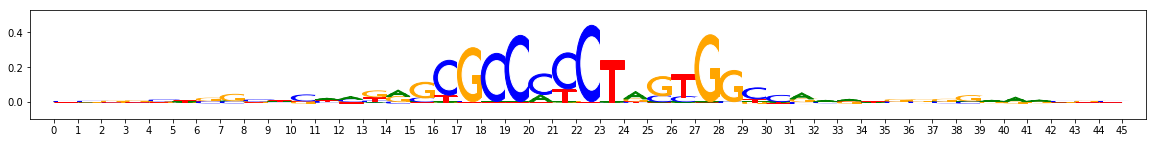

Task 0 actual importance scores:


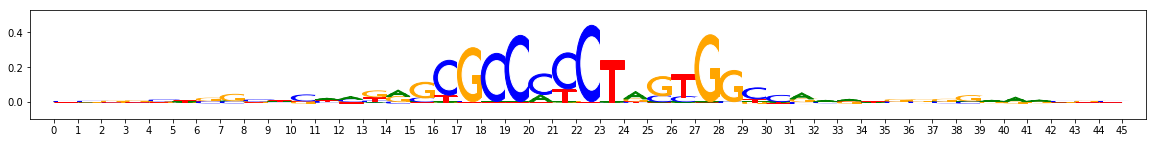

onehot, fwd and rev:


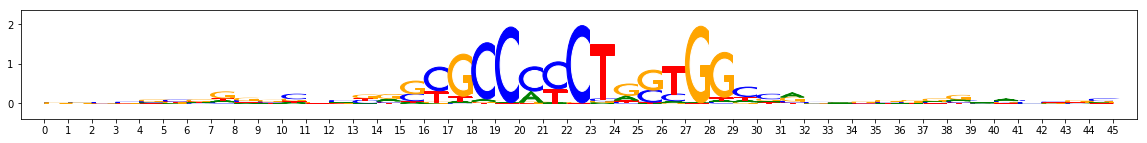

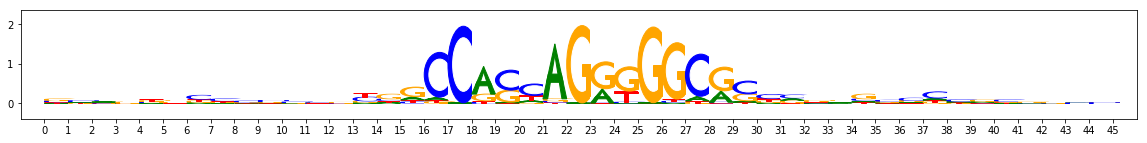

pattern_1
total seqlets: 829
Task 0 hypothetical scores:


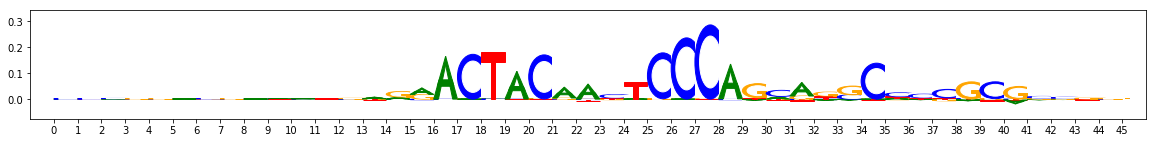

Task 0 actual importance scores:


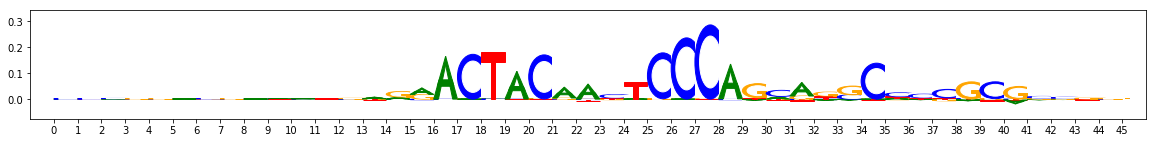

onehot, fwd and rev:


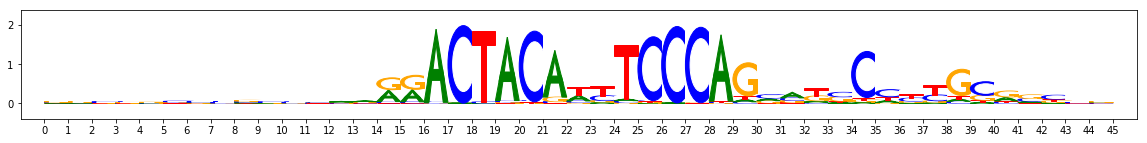

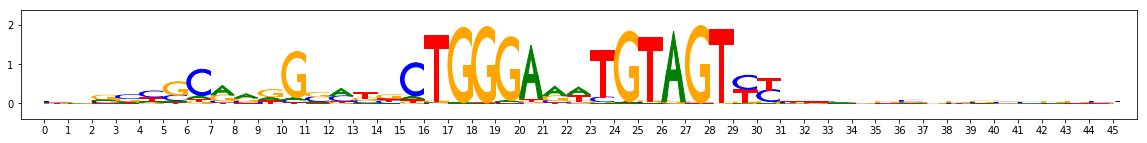

pattern_2
total seqlets: 578
Task 0 hypothetical scores:


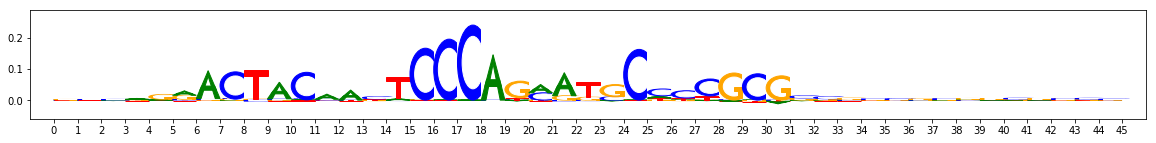

Task 0 actual importance scores:


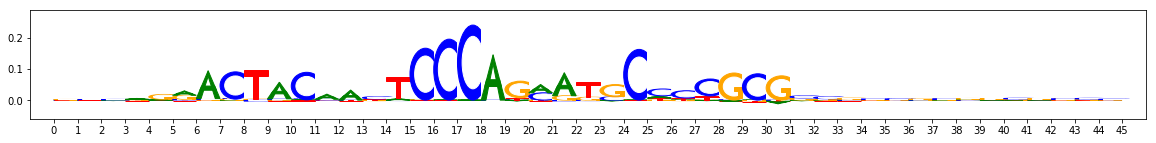

onehot, fwd and rev:


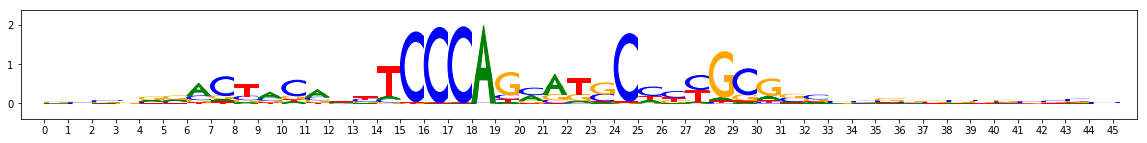

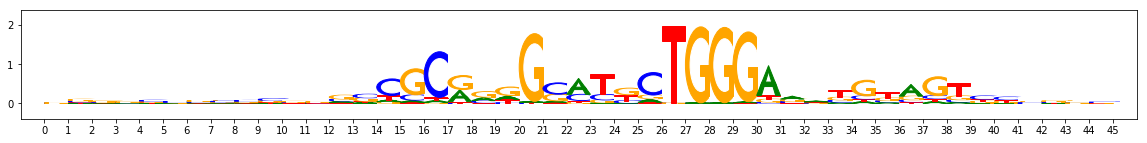

pattern_3
total seqlets: 494
Task 0 hypothetical scores:


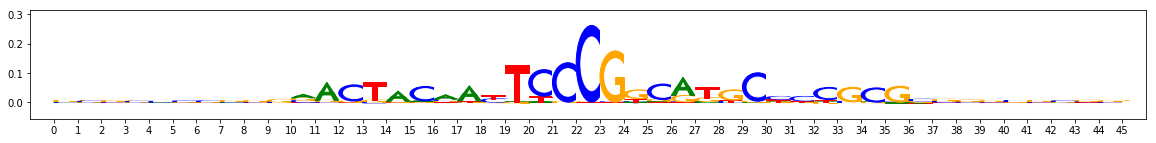

Task 0 actual importance scores:


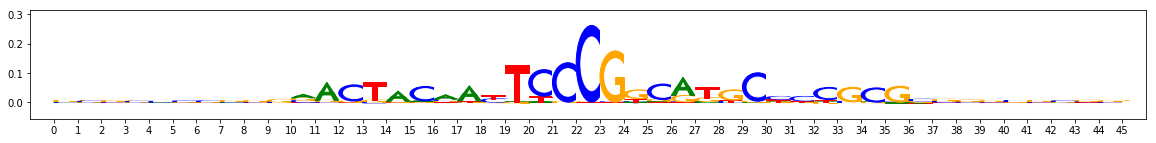

onehot, fwd and rev:


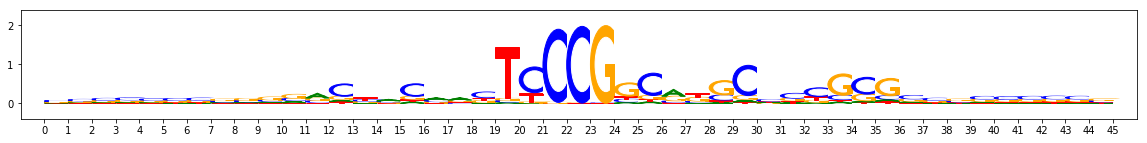

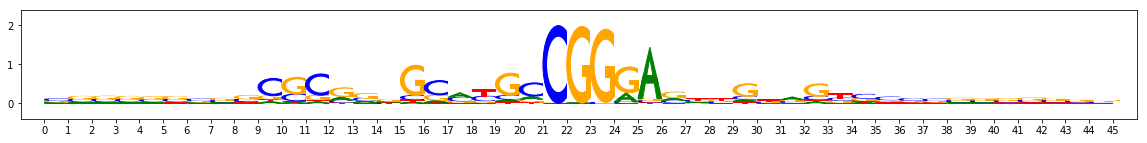

pattern_4
total seqlets: 154
Task 0 hypothetical scores:


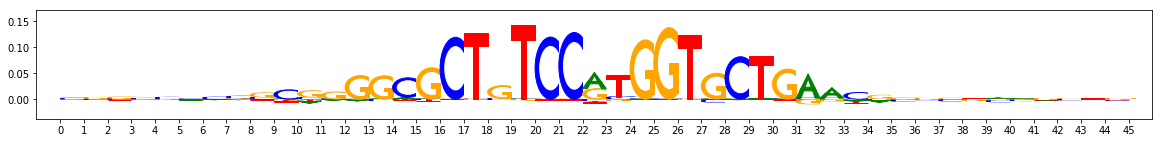

Task 0 actual importance scores:


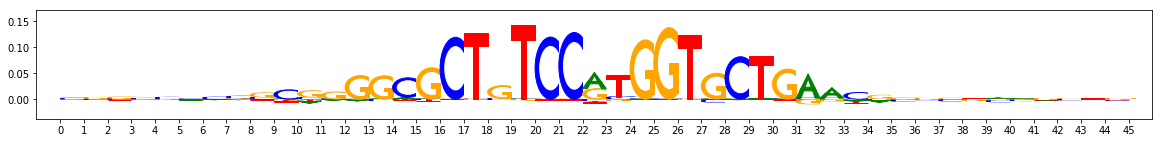

onehot, fwd and rev:


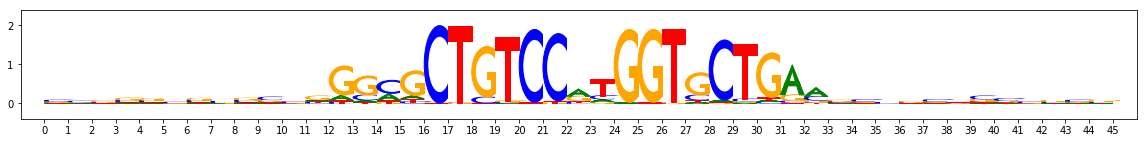

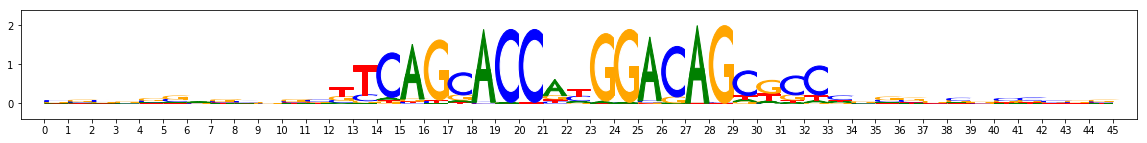

metacluster1
activity pattern: [1 0 1 1 1]
pattern_0
total seqlets: 1472
Task 0 hypothetical scores:


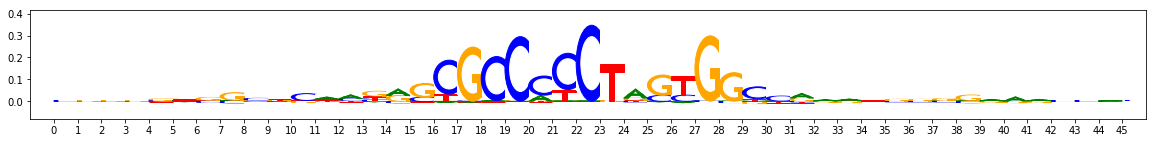

Task 0 actual importance scores:


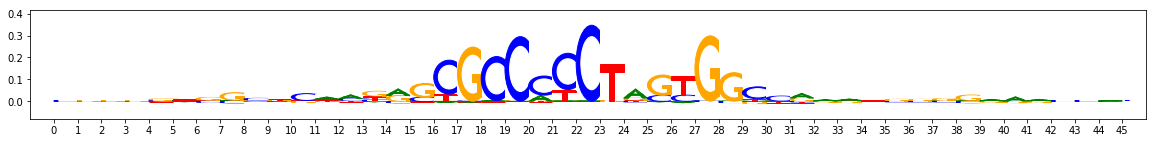

onehot, fwd and rev:


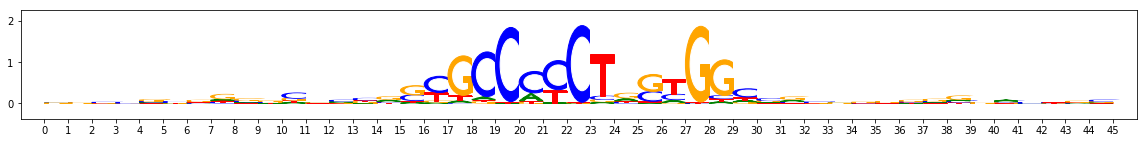

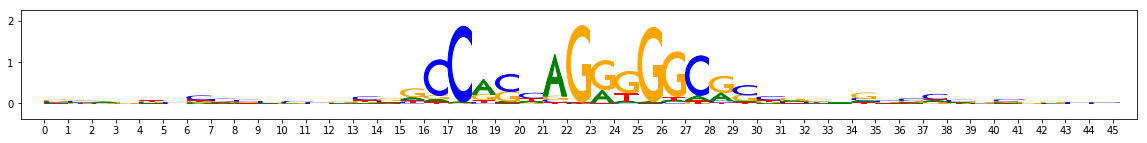

pattern_1
total seqlets: 229
Task 0 hypothetical scores:


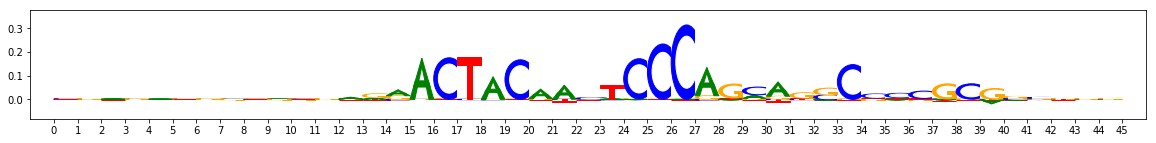

Task 0 actual importance scores:


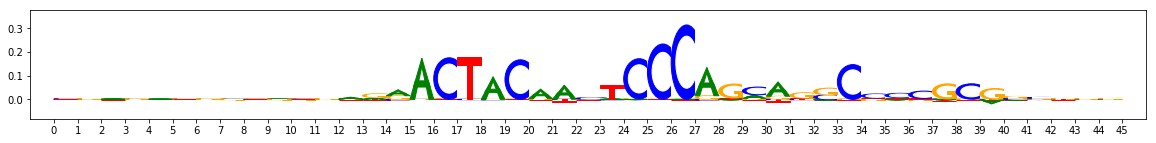

onehot, fwd and rev:


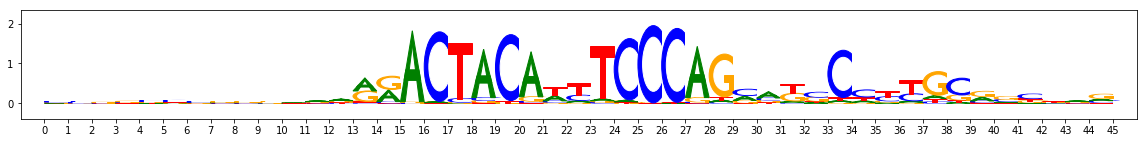

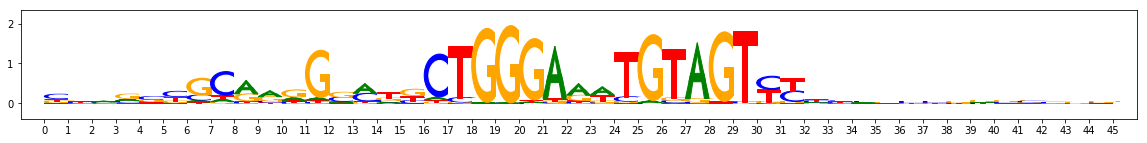

pattern_2
total seqlets: 160
Task 0 hypothetical scores:


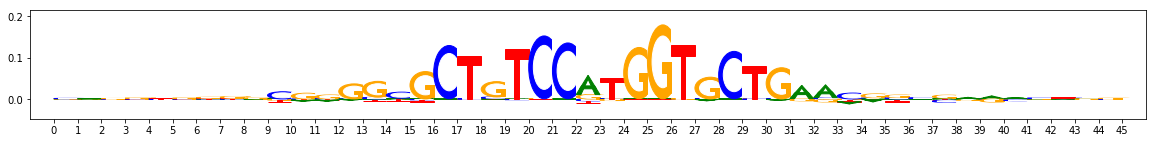

Task 0 actual importance scores:


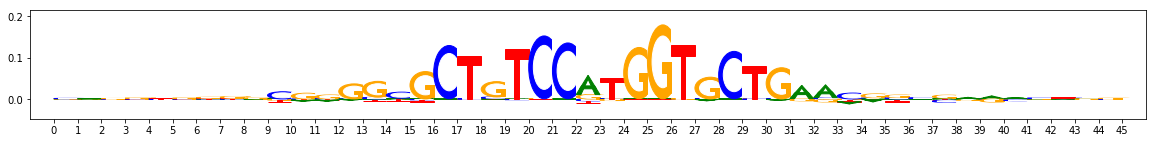

onehot, fwd and rev:


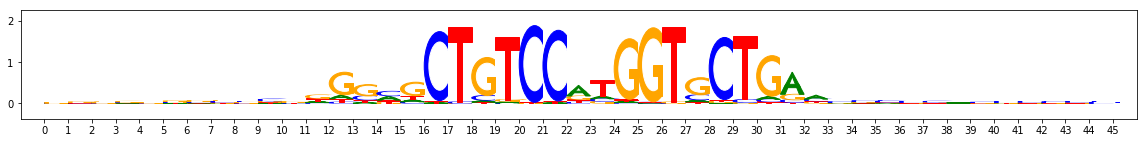

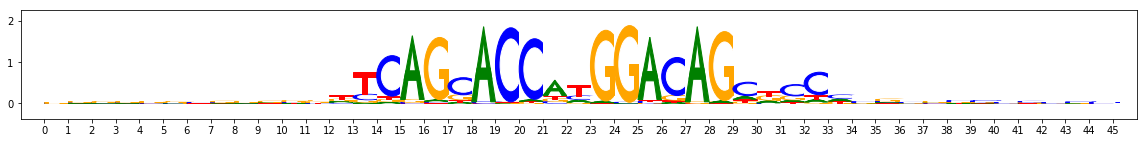

pattern_3
total seqlets: 125
Task 0 hypothetical scores:


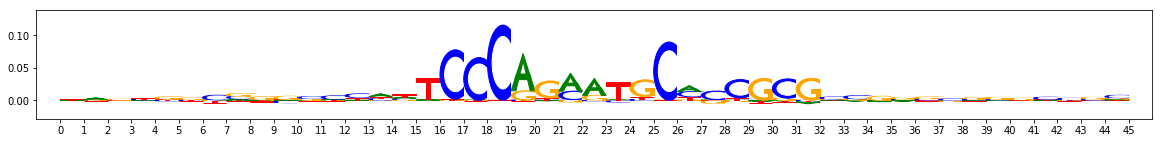

Task 0 actual importance scores:


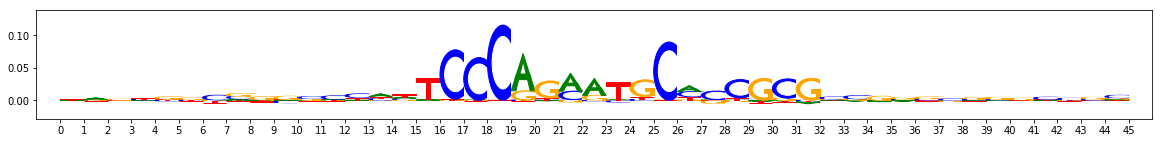

onehot, fwd and rev:


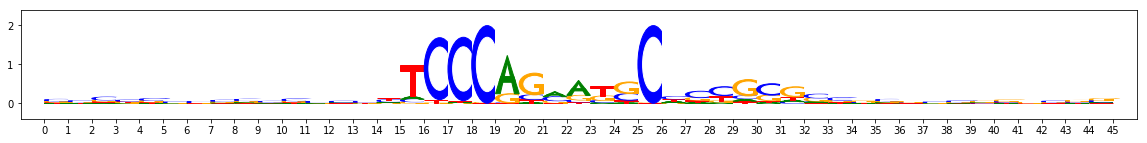

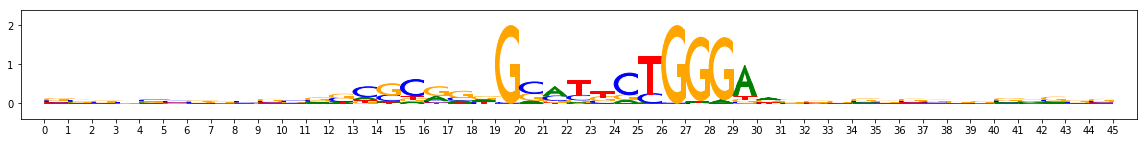

metacluster2
activity pattern: [ 1 -1  1  0  1]
pattern_0
total seqlets: 2500
Task 0 hypothetical scores:


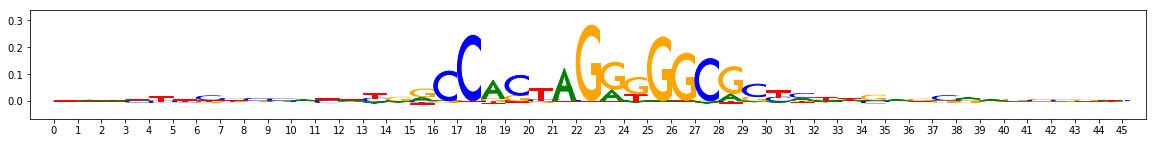

Task 0 actual importance scores:


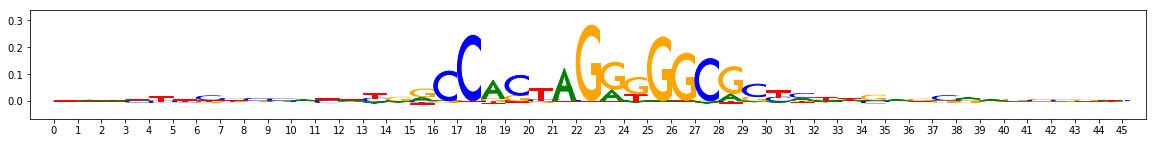

onehot, fwd and rev:


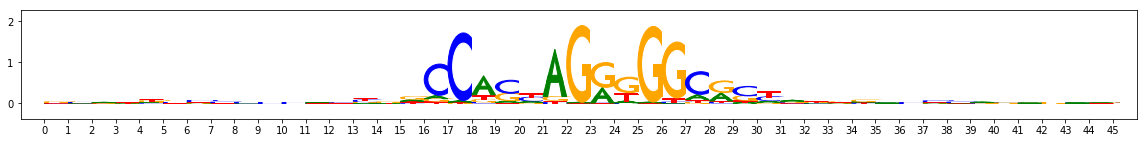

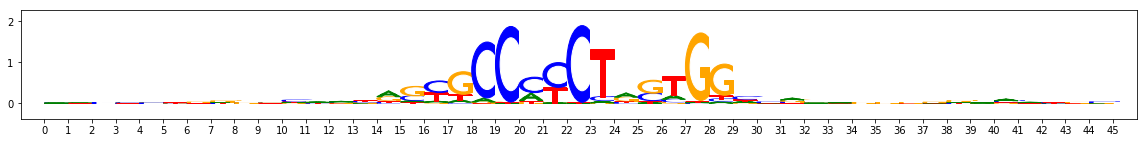

pattern_1
total seqlets: 79
Task 0 hypothetical scores:


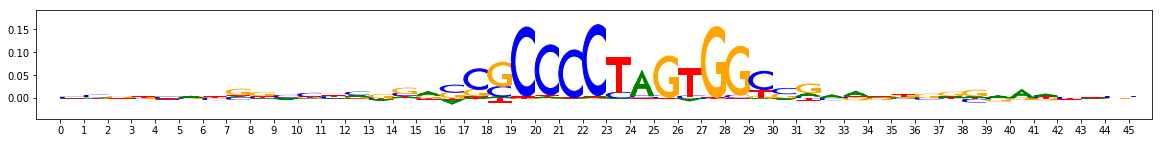

Task 0 actual importance scores:


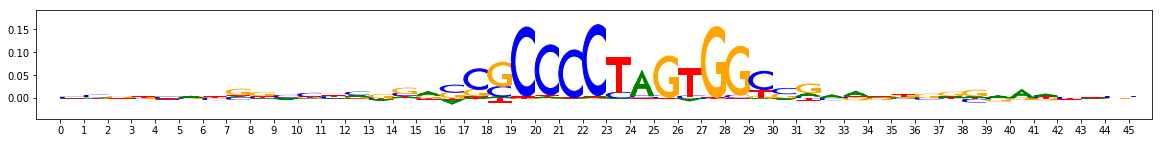

onehot, fwd and rev:


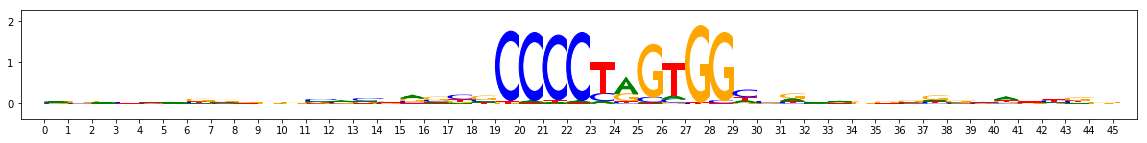

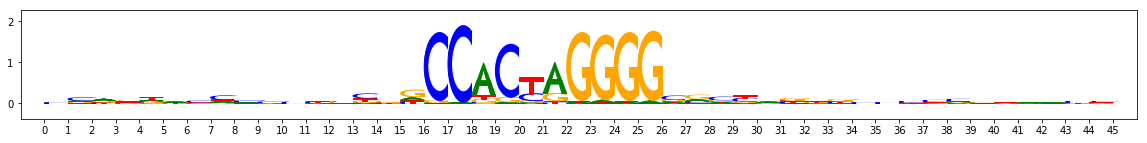

metacluster3
activity pattern: [1 0 1 0 1]
pattern_0
total seqlets: 2008
Task 0 hypothetical scores:


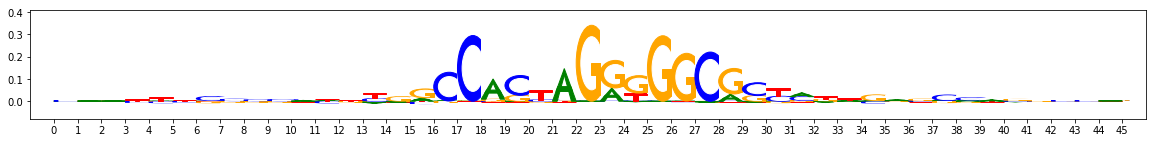

Task 0 actual importance scores:


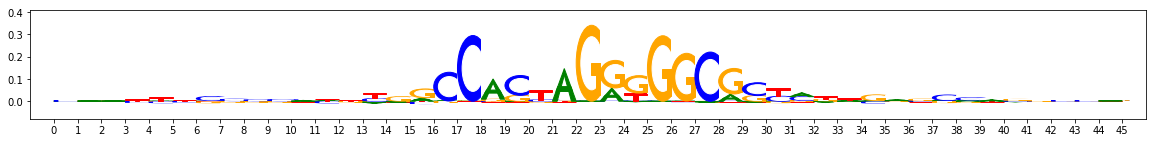

onehot, fwd and rev:


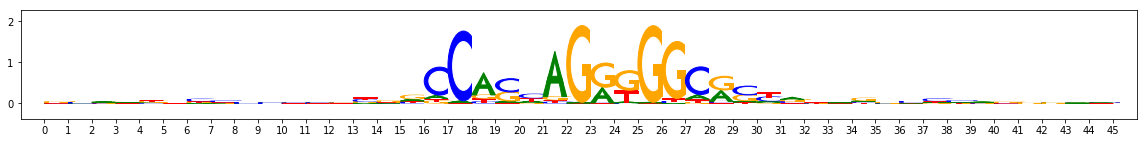

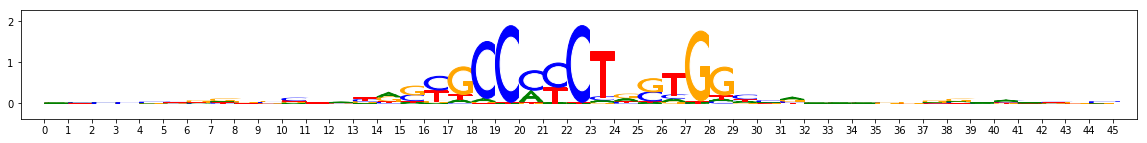

metacluster4
activity pattern: [0 1 0 0 0]
pattern_0
total seqlets: 547
Task 0 hypothetical scores:


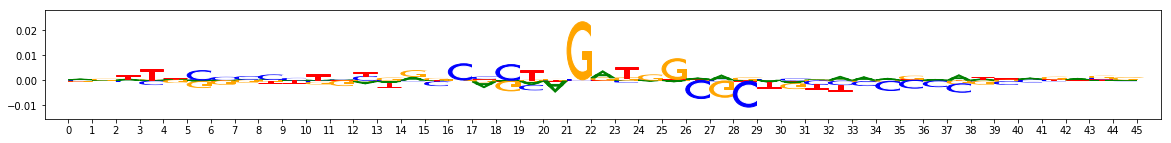

Task 0 actual importance scores:


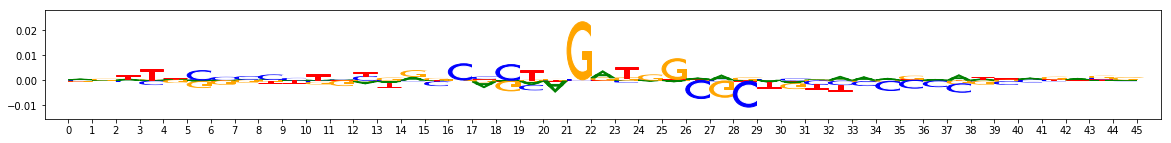

onehot, fwd and rev:


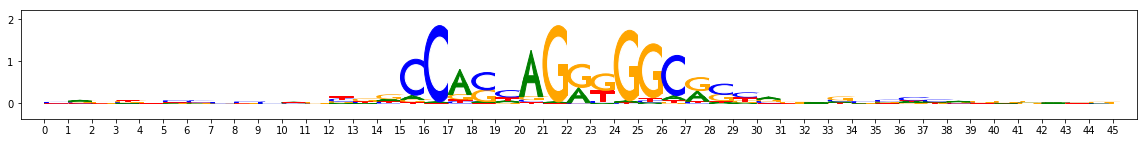

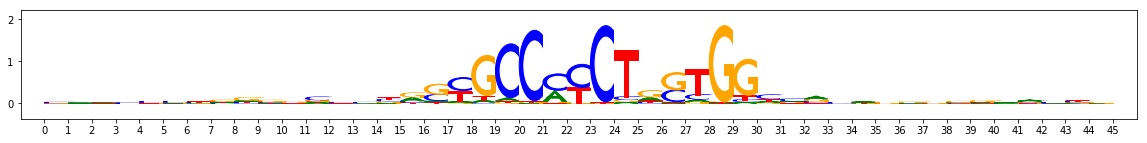

pattern_1
total seqlets: 395
Task 0 hypothetical scores:


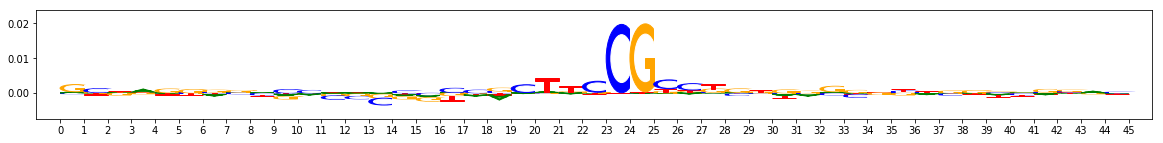

Task 0 actual importance scores:


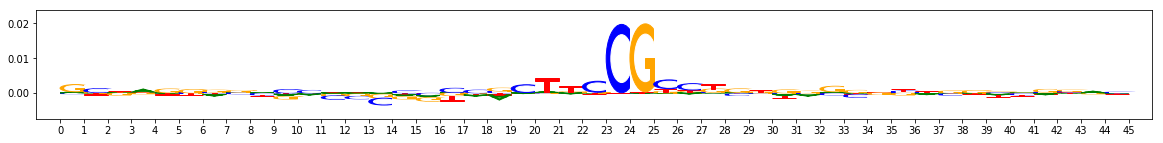

onehot, fwd and rev:


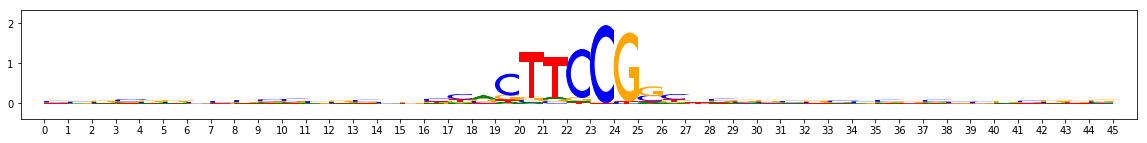

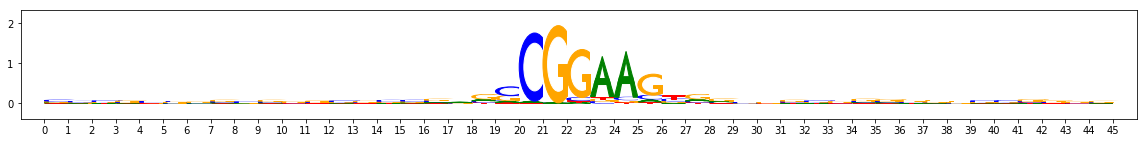

pattern_2
total seqlets: 297
Task 0 hypothetical scores:


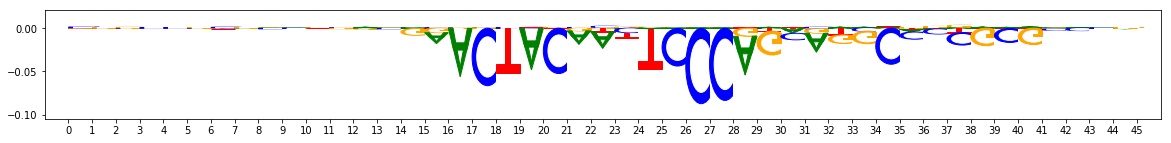

Task 0 actual importance scores:


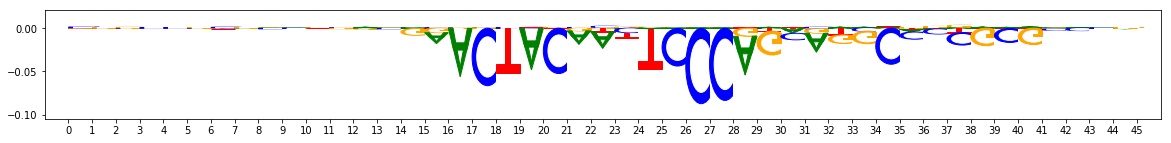

onehot, fwd and rev:


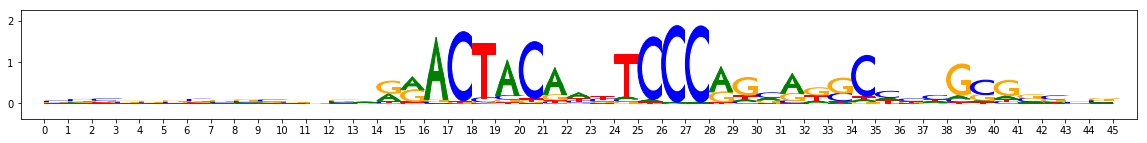

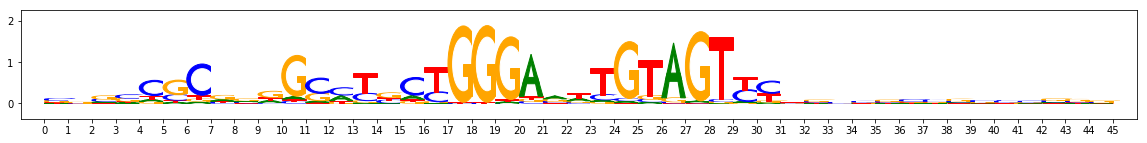

pattern_3
total seqlets: 219
Task 0 hypothetical scores:


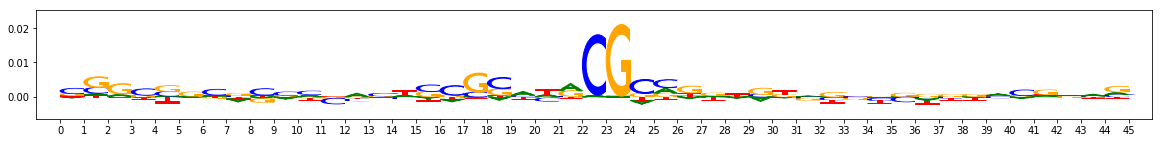

Task 0 actual importance scores:


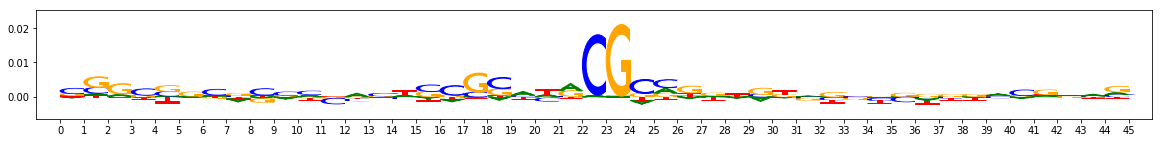

onehot, fwd and rev:


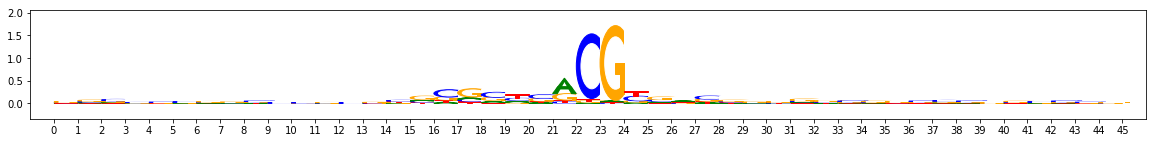

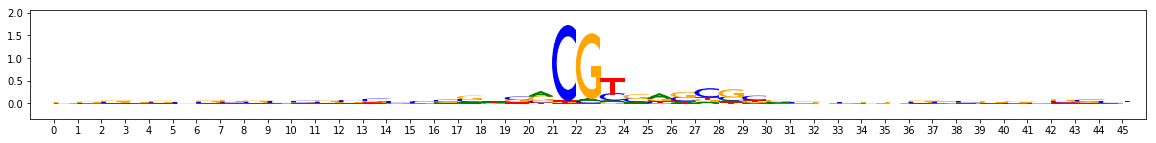

pattern_4
total seqlets: 76
Task 0 hypothetical scores:


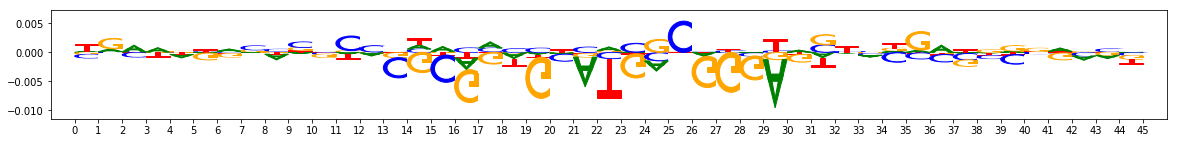

Task 0 actual importance scores:


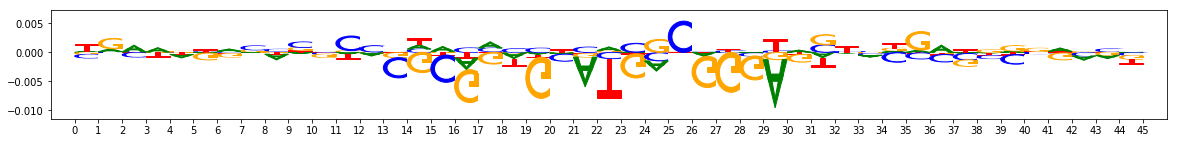

onehot, fwd and rev:


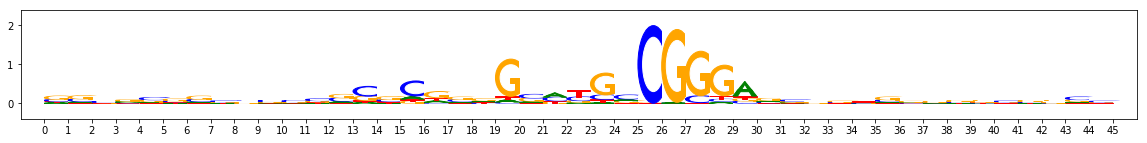

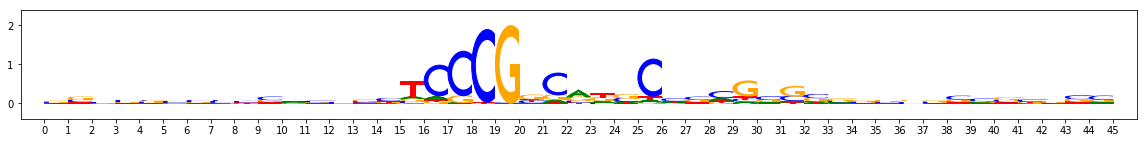

pattern_5
total seqlets: 71
Task 0 hypothetical scores:


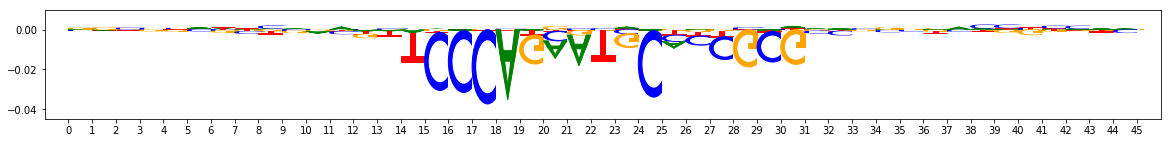

Task 0 actual importance scores:


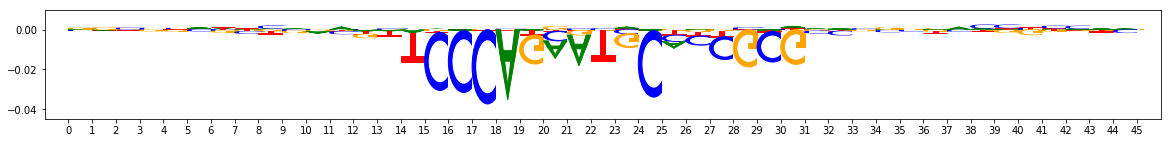

onehot, fwd and rev:


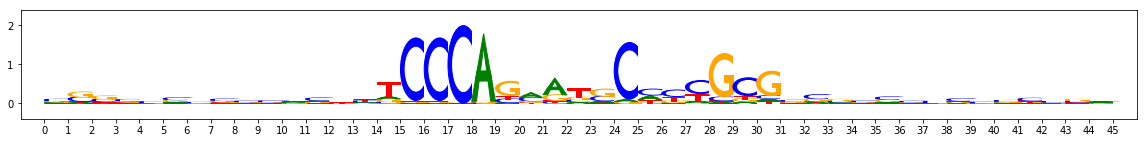

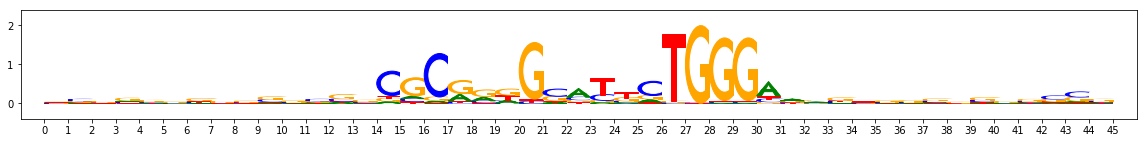

metacluster5
activity pattern: [1 1 1 0 1]
pattern_0
total seqlets: 769
Task 0 hypothetical scores:


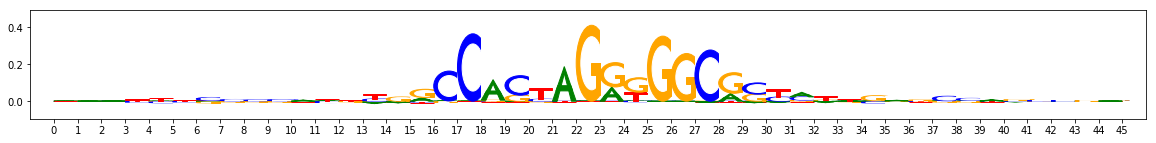

Task 0 actual importance scores:


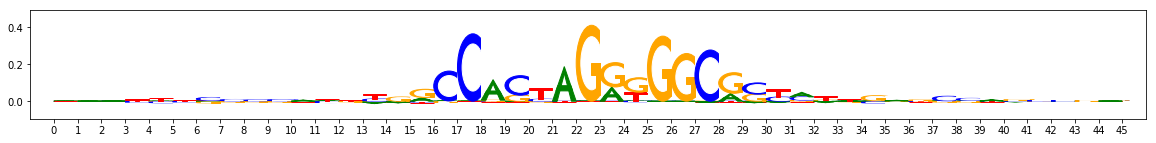

onehot, fwd and rev:


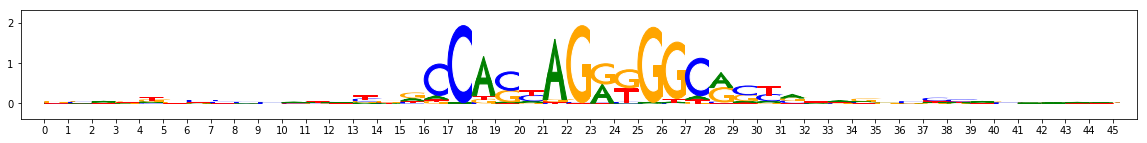

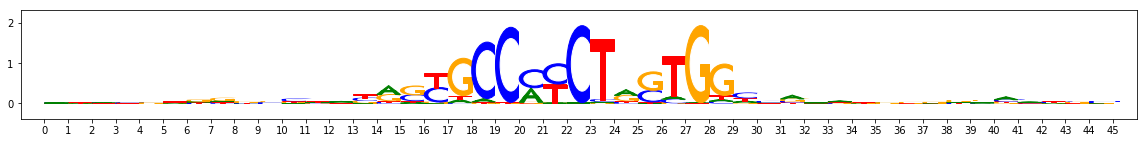

metacluster6
activity pattern: [ 0  0 -1 -1  0]
pattern_0
total seqlets: 286
Task 0 hypothetical scores:


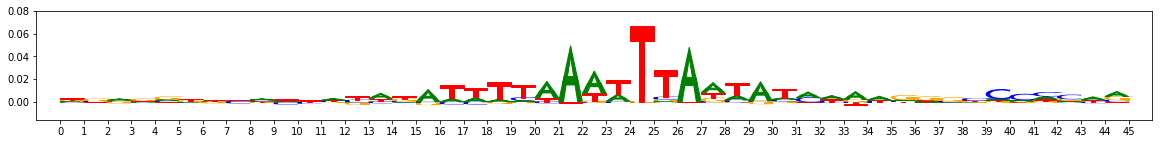

Task 0 actual importance scores:


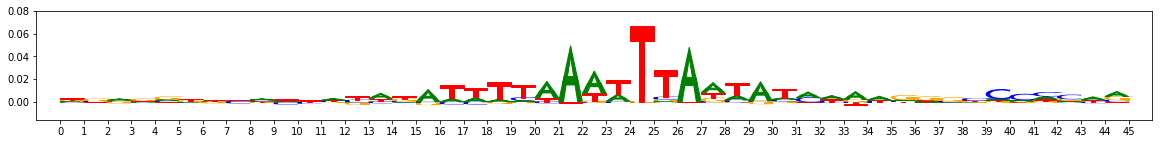

onehot, fwd and rev:


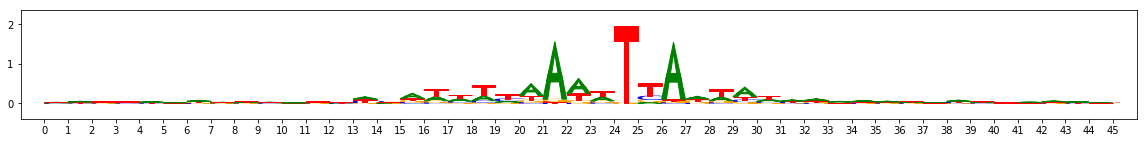

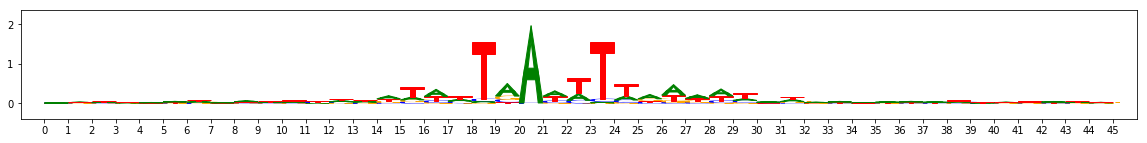

pattern_1
total seqlets: 103
Task 0 hypothetical scores:


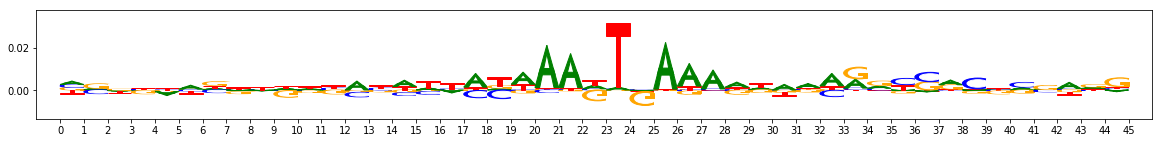

Task 0 actual importance scores:


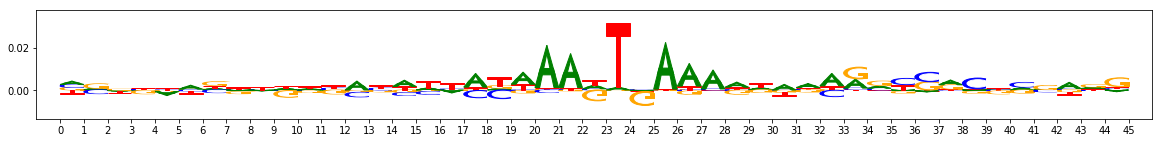

onehot, fwd and rev:


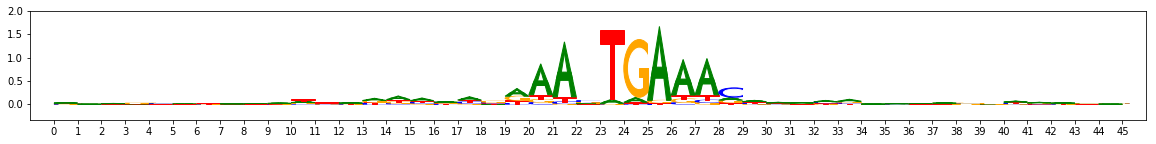

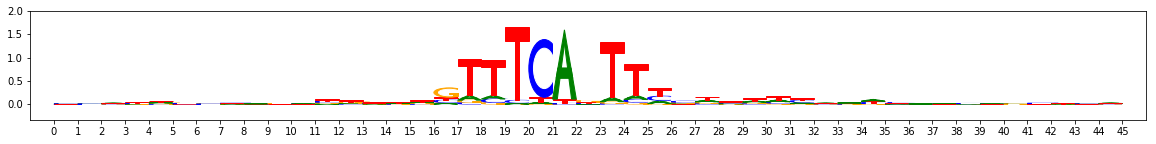

pattern_2
total seqlets: 96
Task 0 hypothetical scores:


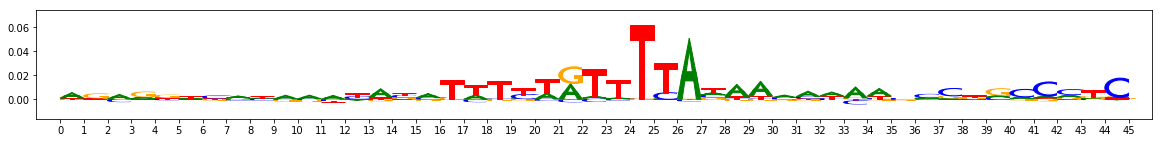

Task 0 actual importance scores:


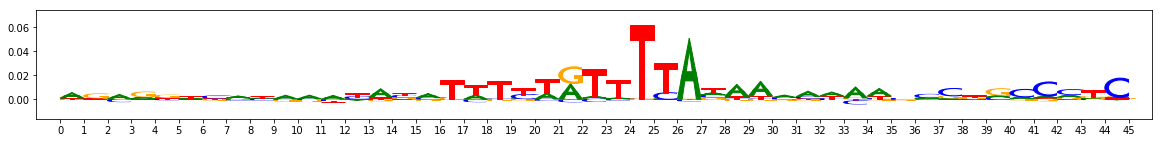

onehot, fwd and rev:


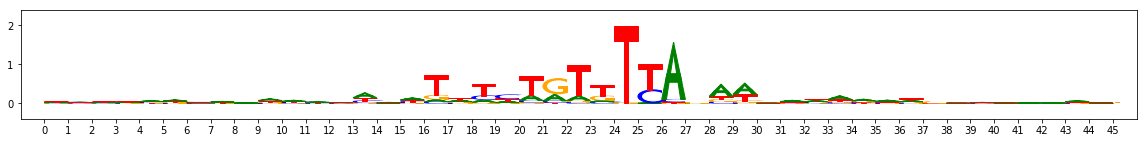

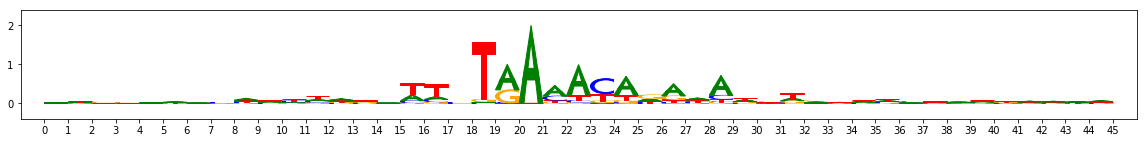

pattern_3
total seqlets: 89
Task 0 hypothetical scores:


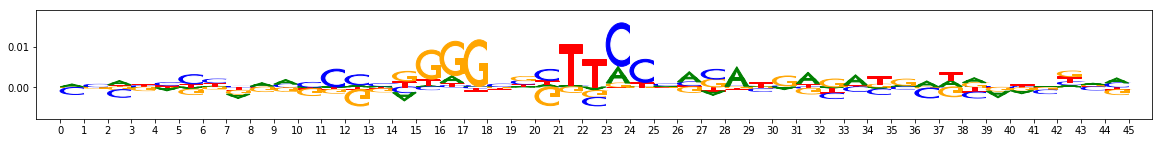

Task 0 actual importance scores:


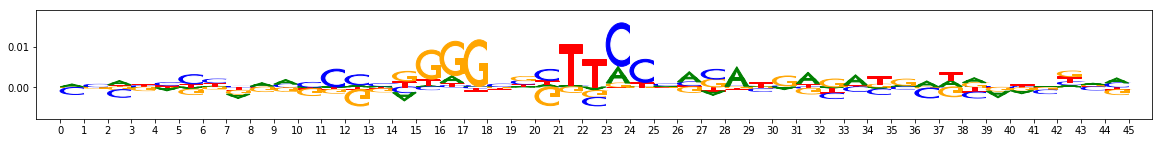

onehot, fwd and rev:


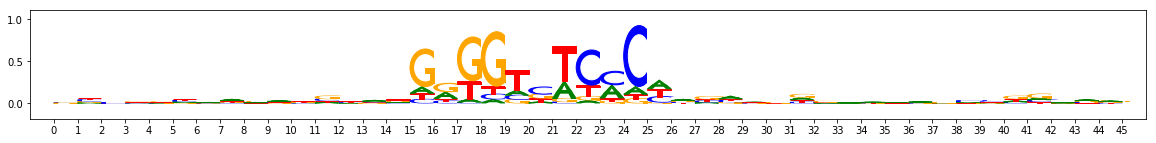

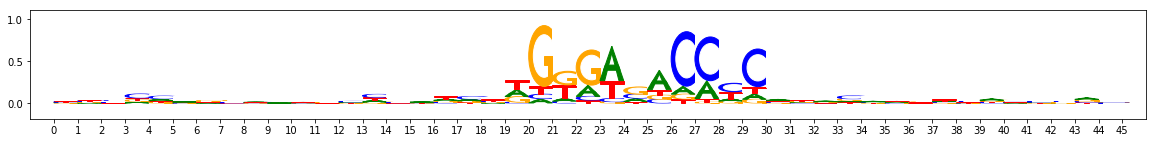

metacluster7
activity pattern: [ 0  0 -1 -1 -1]
pattern_0
total seqlets: 189
Task 0 hypothetical scores:


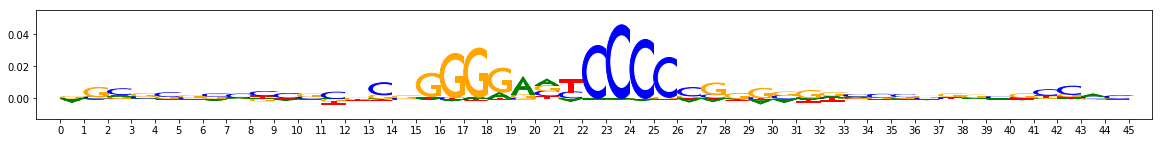

Task 0 actual importance scores:


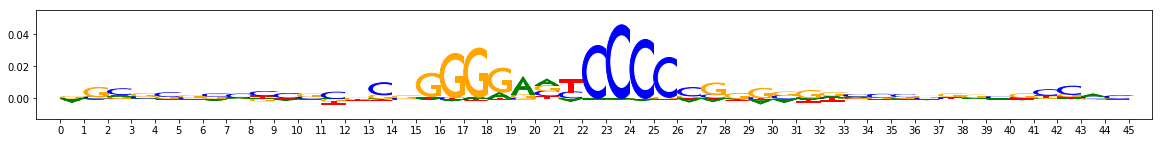

onehot, fwd and rev:


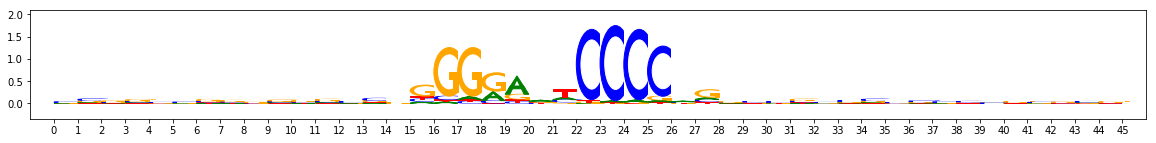

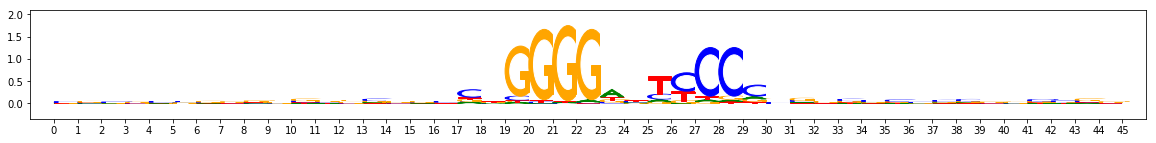

pattern_1
total seqlets: 146
Task 0 hypothetical scores:


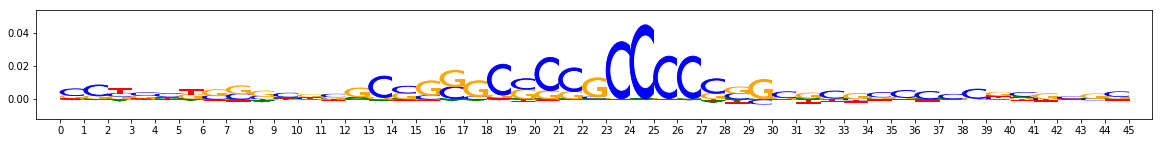

Task 0 actual importance scores:


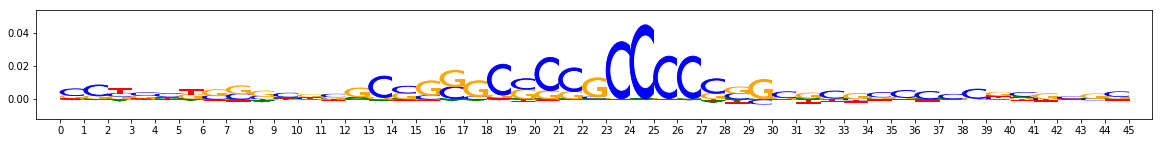

onehot, fwd and rev:


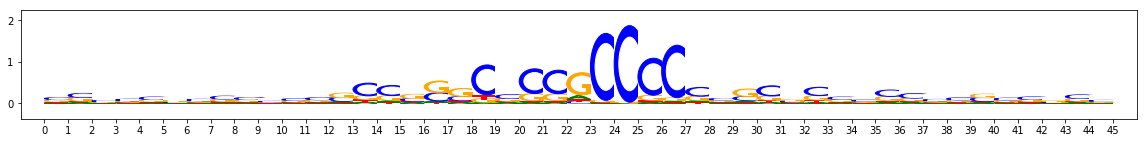

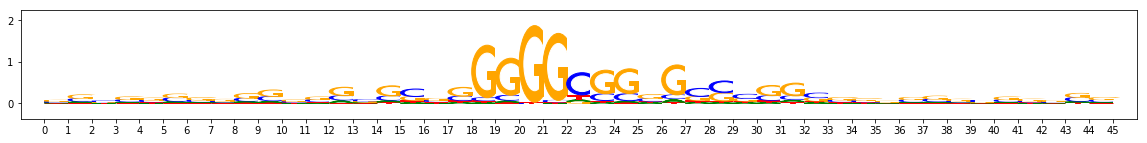

pattern_2
total seqlets: 132
Task 0 hypothetical scores:


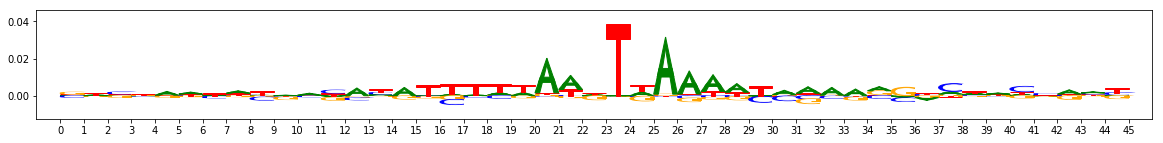

Task 0 actual importance scores:


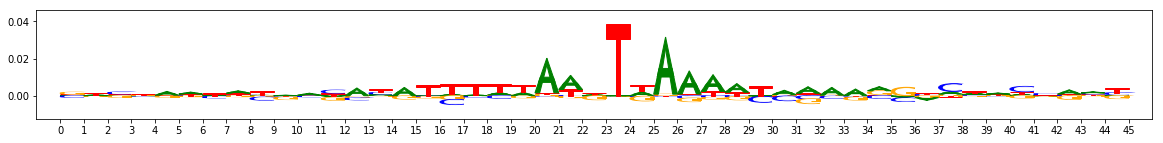

onehot, fwd and rev:


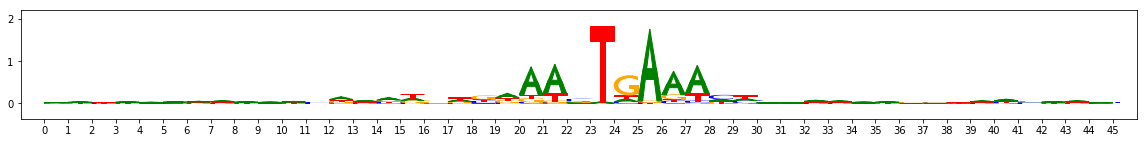

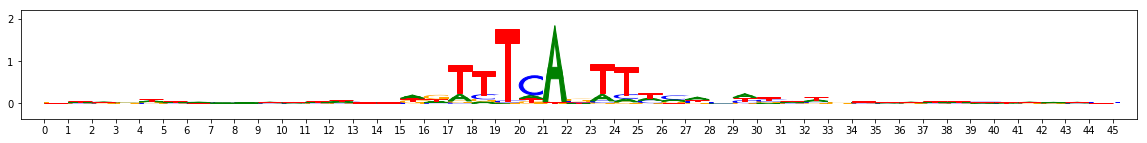

metacluster8
activity pattern: [ 0  1 -1  0  0]
pattern_0
total seqlets: 222
Task 0 hypothetical scores:


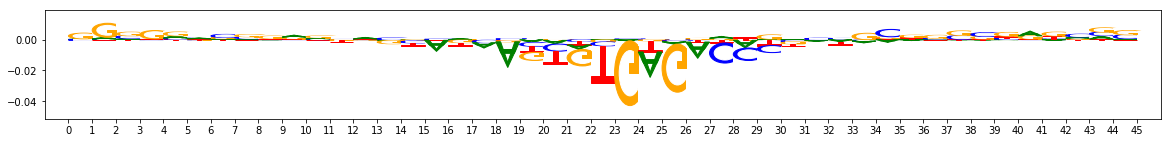

Task 0 actual importance scores:


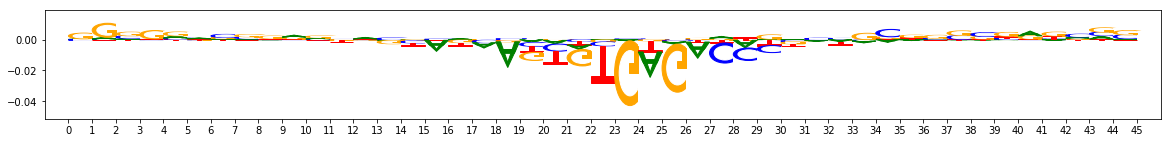

onehot, fwd and rev:


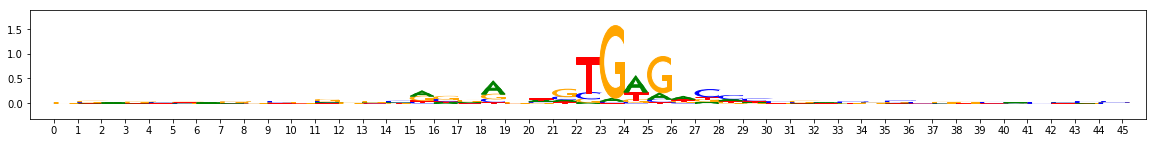

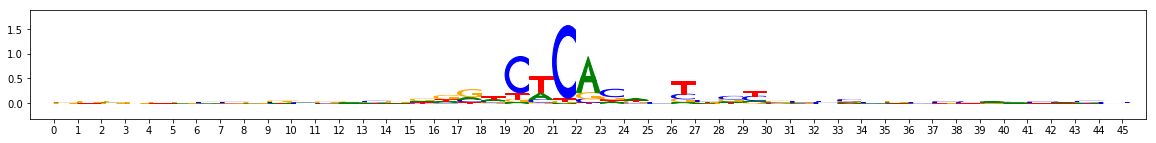

metacluster9
activity pattern: [1 0 0 0 0]
pattern_0
total seqlets: 494
Task 0 hypothetical scores:


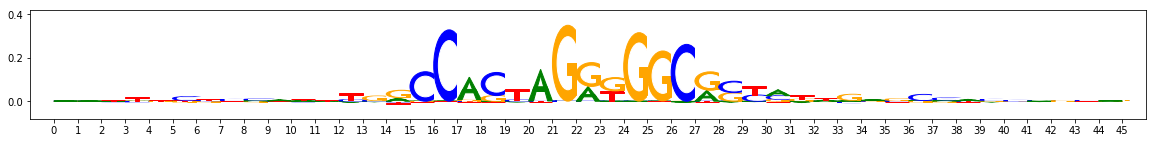

Task 0 actual importance scores:


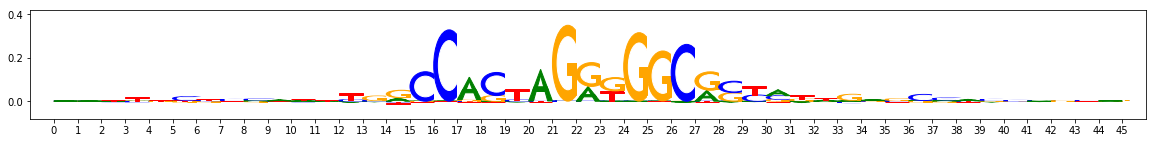

onehot, fwd and rev:


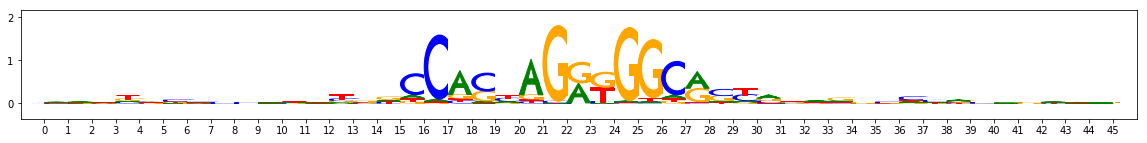

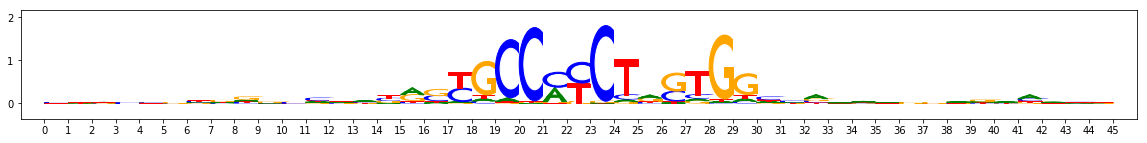

metacluster10
activity pattern: [-1  1 -1 -1 -1]
pattern_0
total seqlets: 352
Task 0 hypothetical scores:


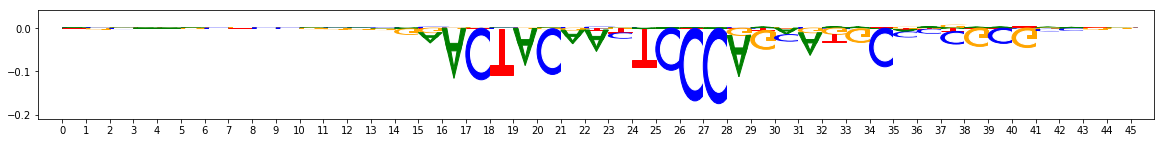

Task 0 actual importance scores:


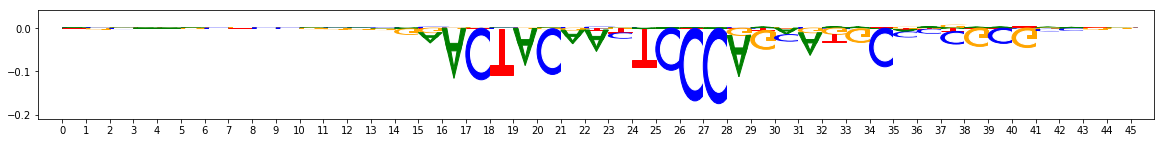

onehot, fwd and rev:


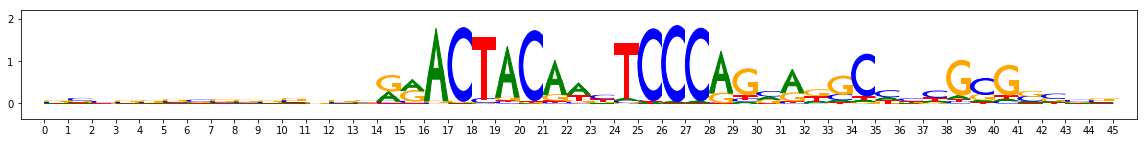

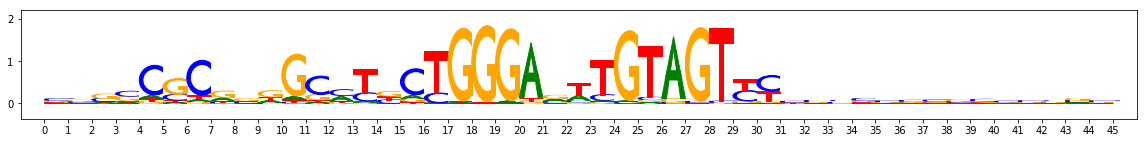

pattern_1
total seqlets: 204
Task 0 hypothetical scores:


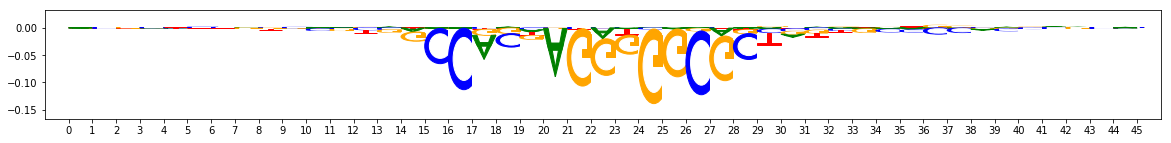

Task 0 actual importance scores:


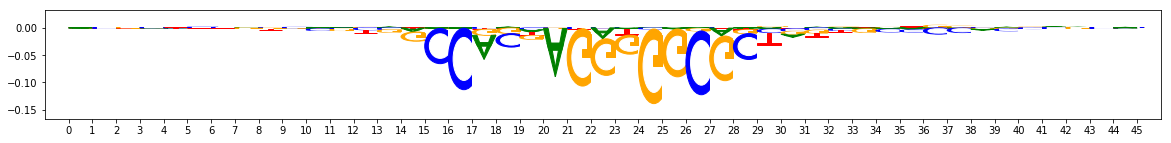

onehot, fwd and rev:


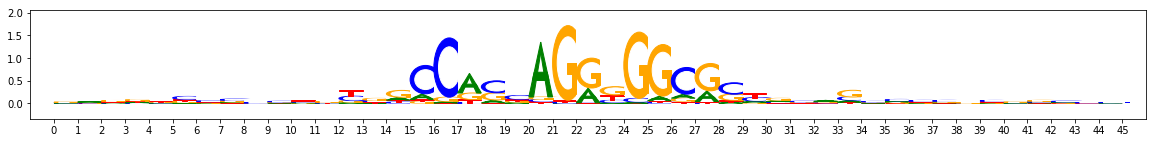

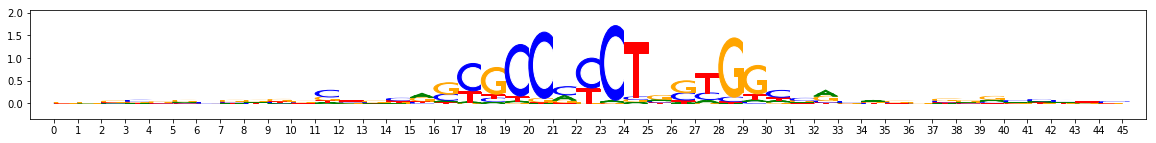

metacluster11
activity pattern: [0 1 0 1 0]
pattern_0
total seqlets: 328
Task 0 hypothetical scores:


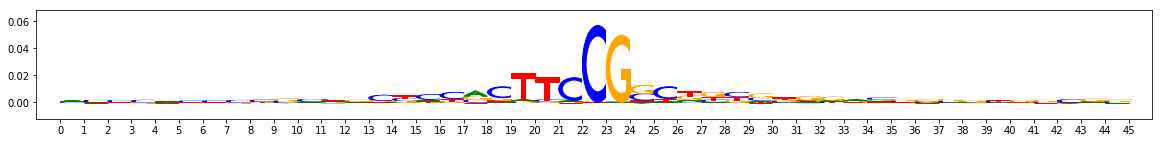

Task 0 actual importance scores:


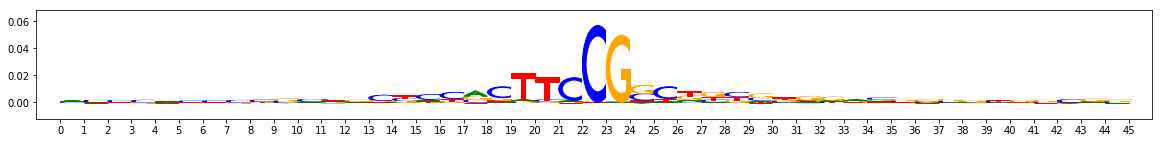

onehot, fwd and rev:


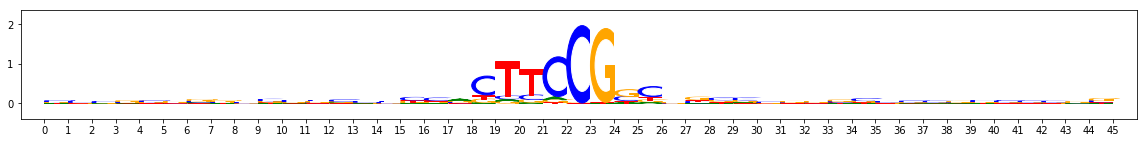

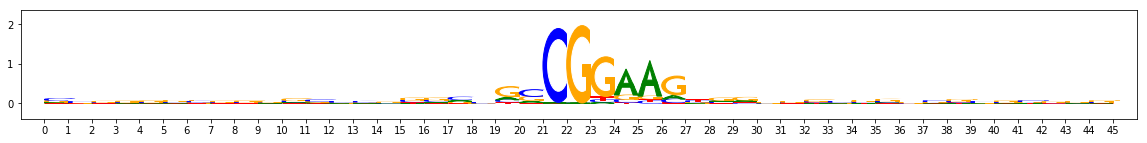

pattern_1
total seqlets: 76
Task 0 hypothetical scores:


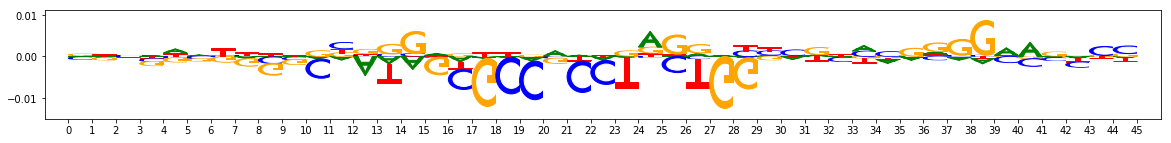

Task 0 actual importance scores:


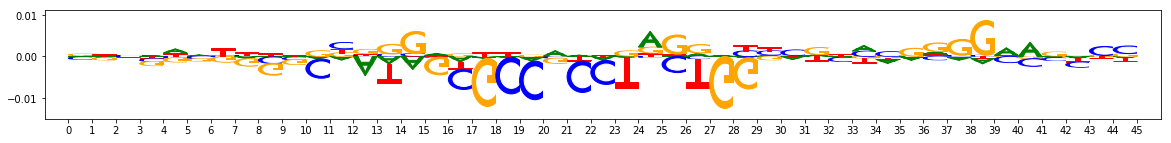

onehot, fwd and rev:


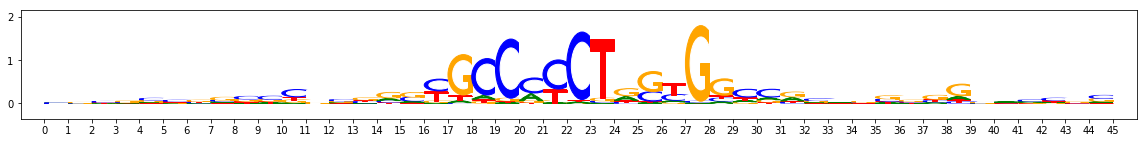

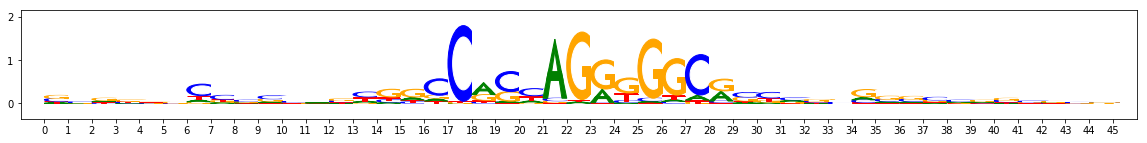

pattern_2
total seqlets: 73
Task 0 hypothetical scores:


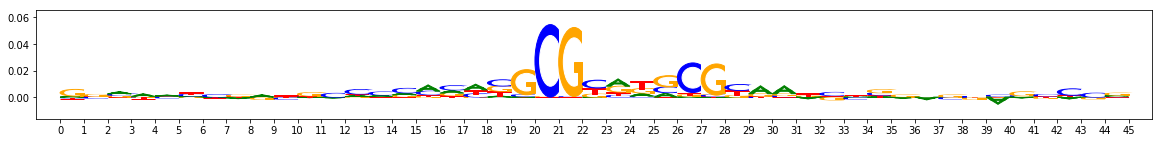

Task 0 actual importance scores:


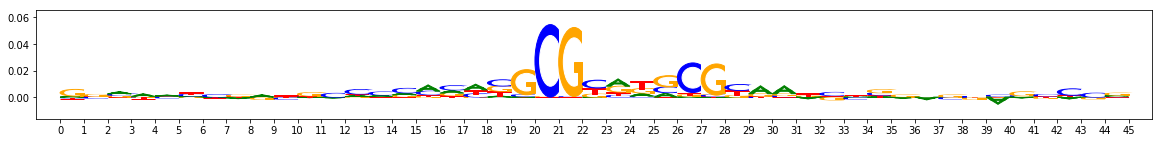

onehot, fwd and rev:


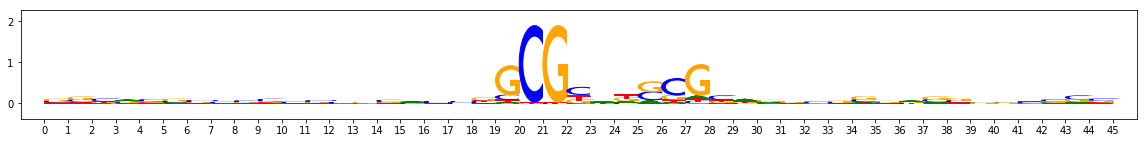

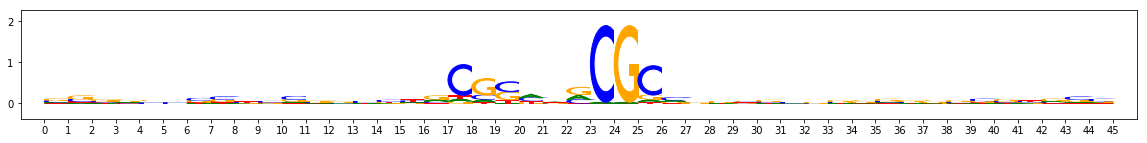

metacluster12
activity pattern: [0 1 0 1 1]
pattern_0
total seqlets: 379
Task 0 hypothetical scores:


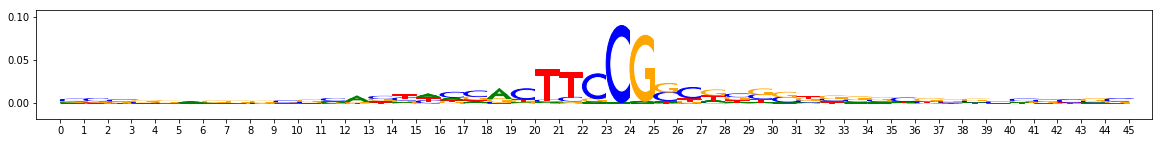

Task 0 actual importance scores:


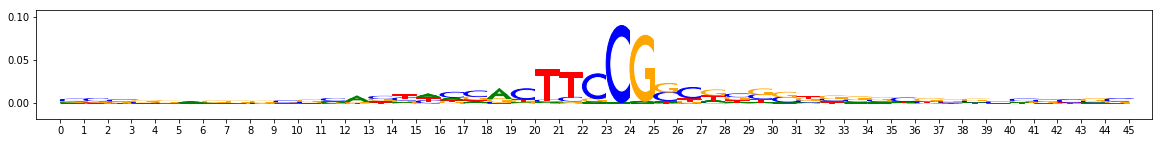

onehot, fwd and rev:


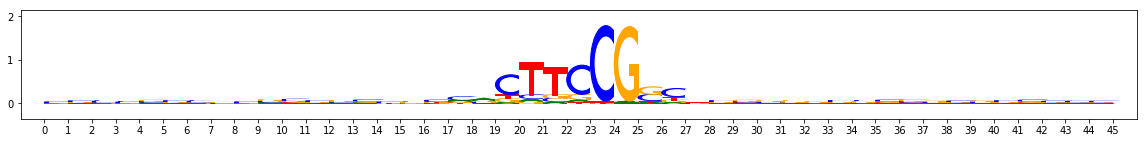

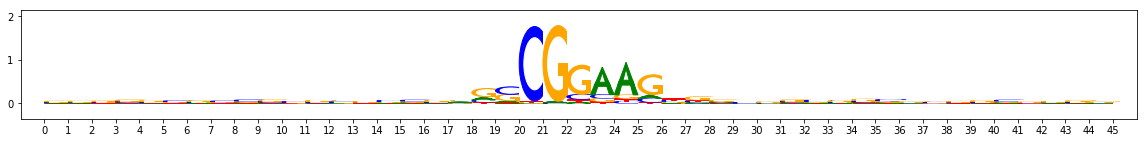

metacluster13
activity pattern: [ 0  1 -1 -1 -1]
pattern_0
total seqlets: 113
Task 0 hypothetical scores:


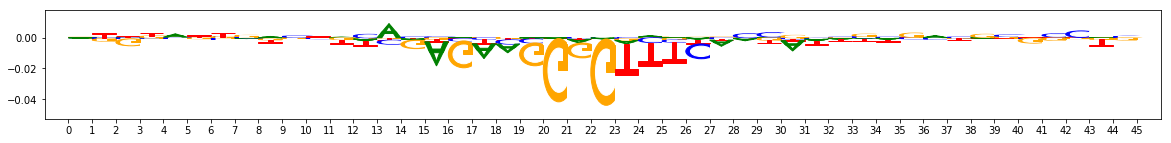

Task 0 actual importance scores:


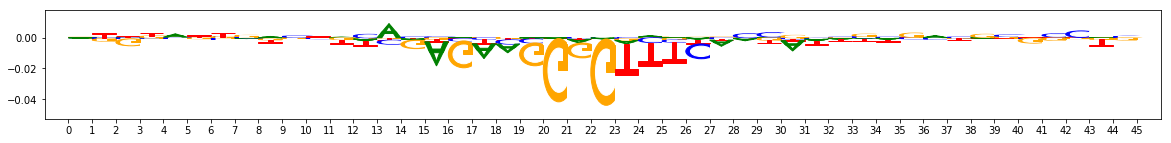

onehot, fwd and rev:


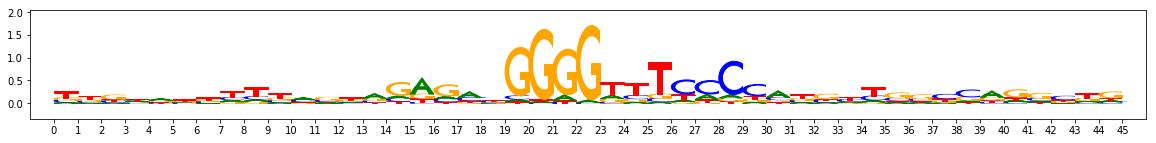

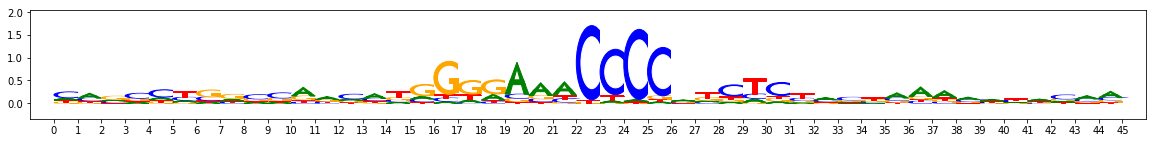

pattern_1
total seqlets: 122
Task 0 hypothetical scores:


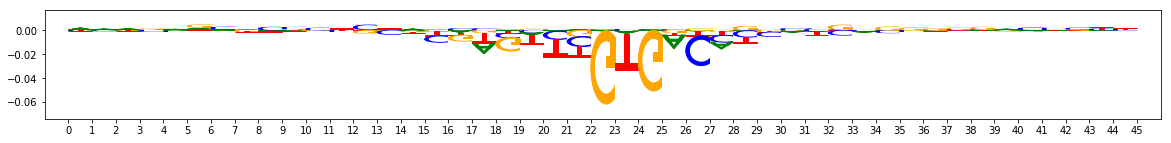

Task 0 actual importance scores:


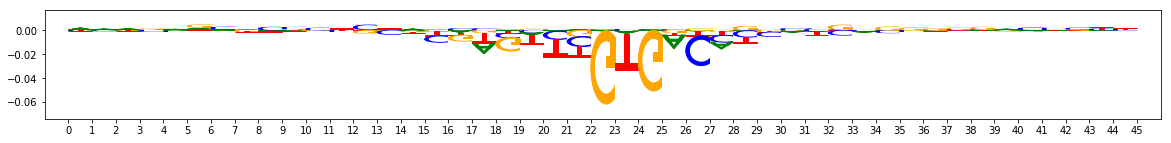

onehot, fwd and rev:


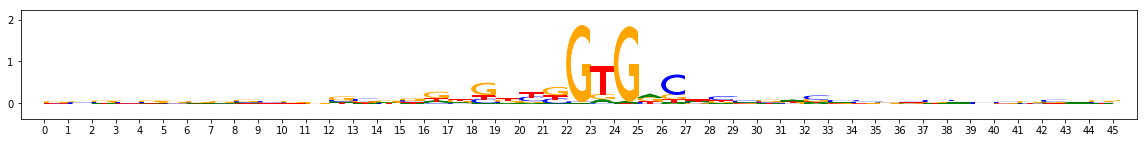

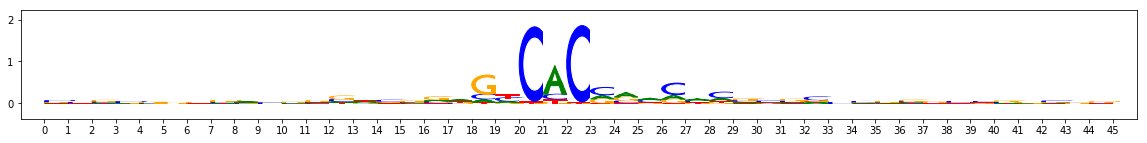

pattern_2
total seqlets: 138
Task 0 hypothetical scores:


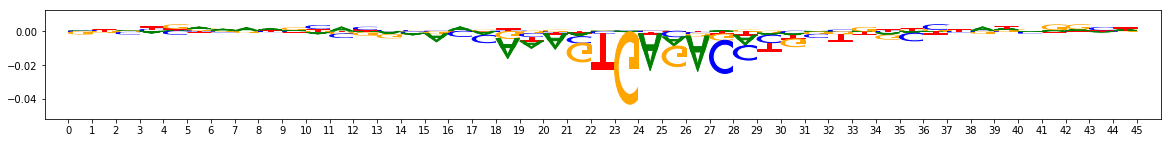

Task 0 actual importance scores:


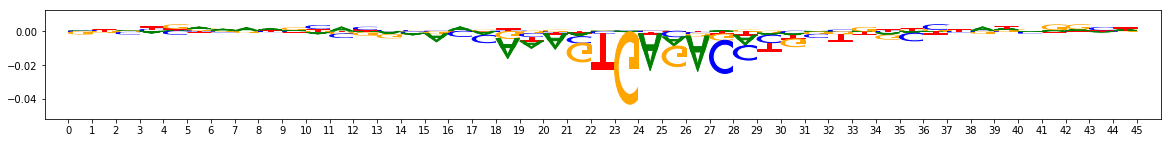

onehot, fwd and rev:


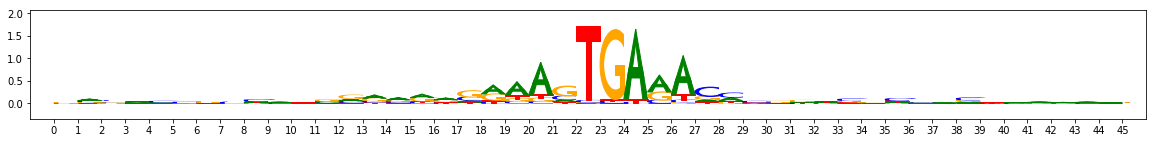

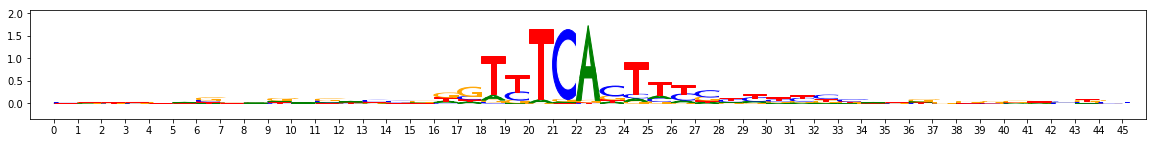

pattern_3
total seqlets: 128
Task 0 hypothetical scores:


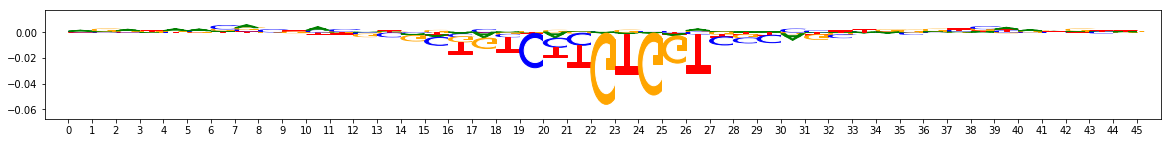

Task 0 actual importance scores:


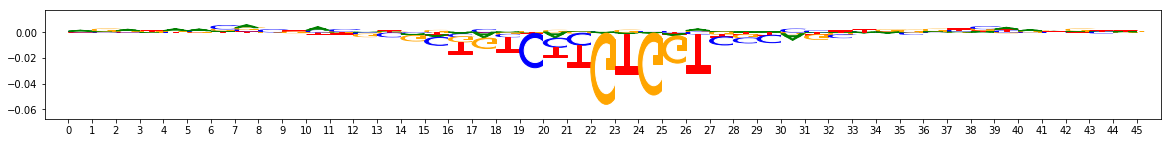

onehot, fwd and rev:


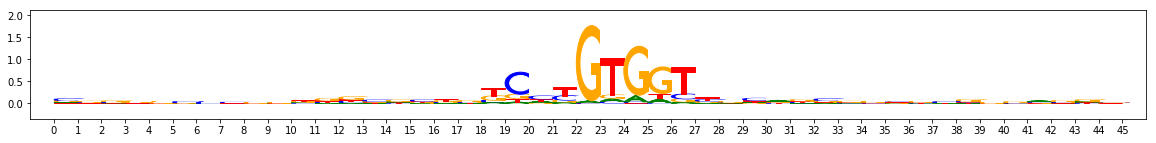

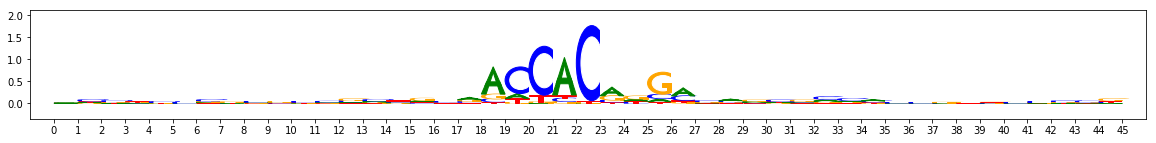

metacluster14
activity pattern: [1 0 0 0 1]
pattern_0
total seqlets: 485
Task 0 hypothetical scores:


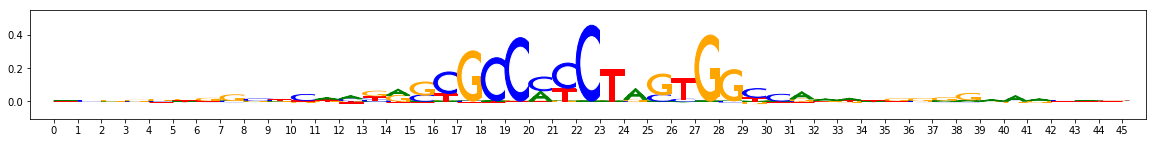

Task 0 actual importance scores:


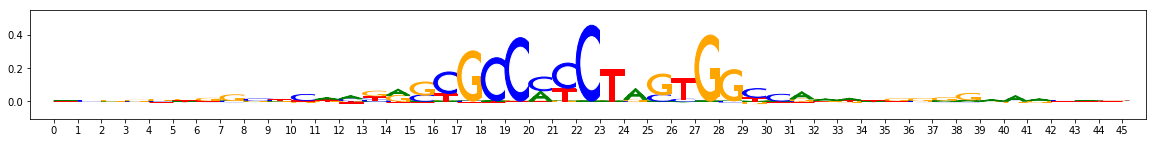

onehot, fwd and rev:


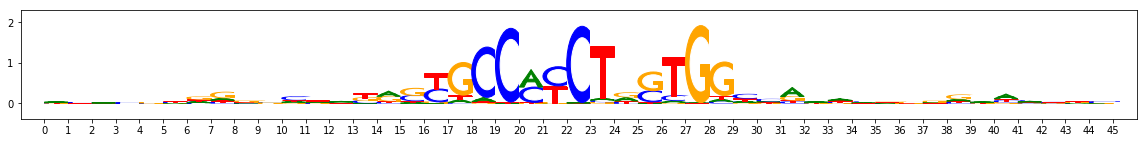

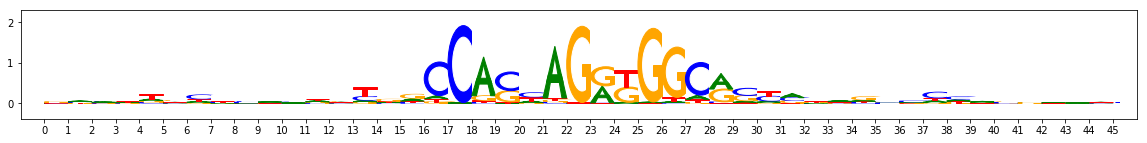

metacluster15
activity pattern: [ 0  1 -1 -1  0]
pattern_0
total seqlets: 130
Task 0 hypothetical scores:


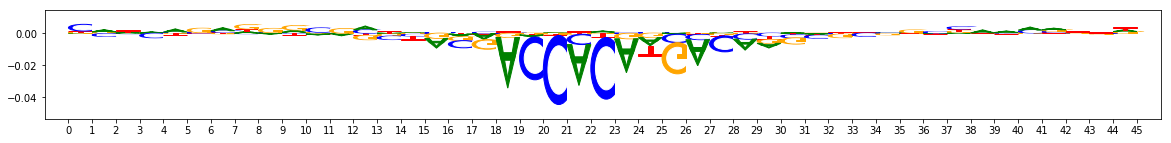

Task 0 actual importance scores:


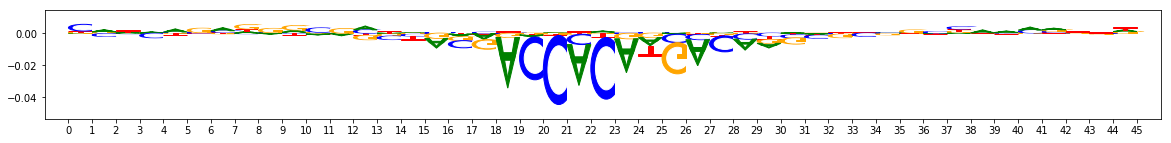

onehot, fwd and rev:


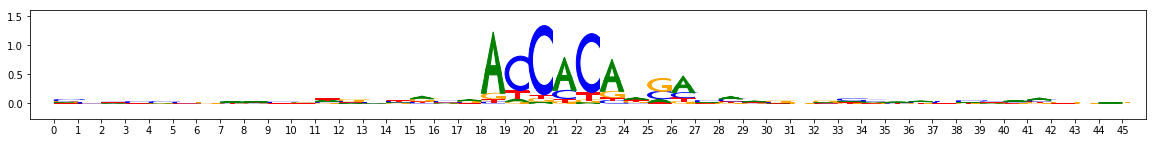

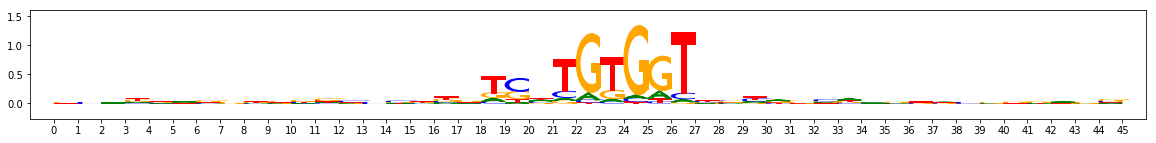

pattern_1
total seqlets: 141
Task 0 hypothetical scores:


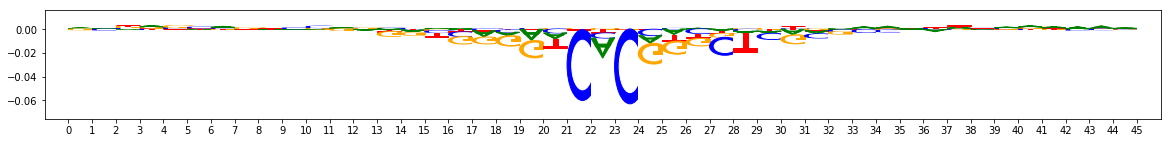

Task 0 actual importance scores:


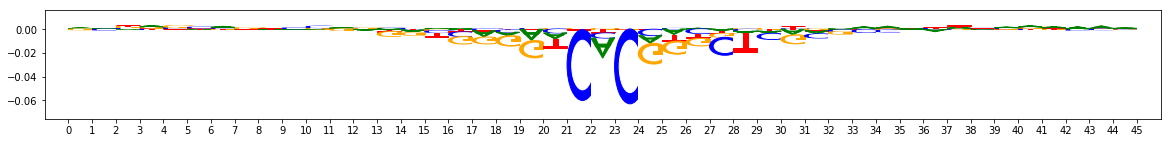

onehot, fwd and rev:


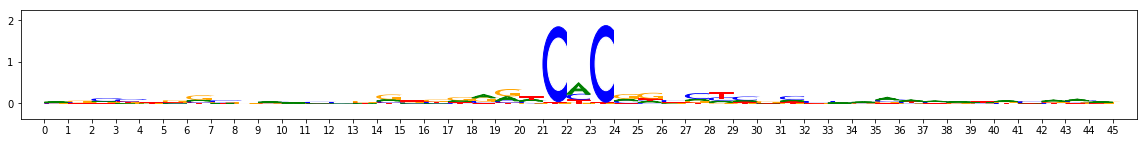

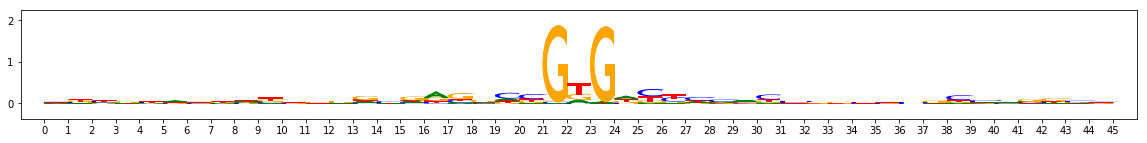

pattern_2
total seqlets: 102
Task 0 hypothetical scores:


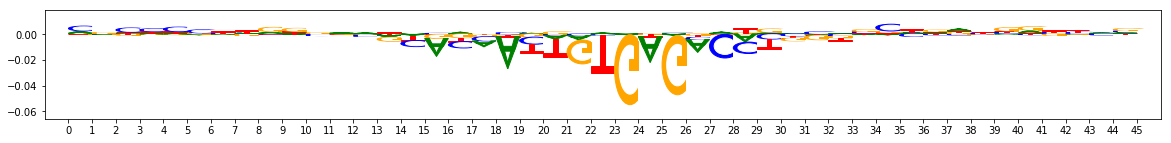

Task 0 actual importance scores:


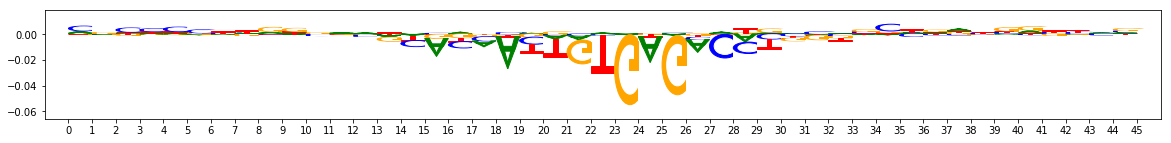

onehot, fwd and rev:


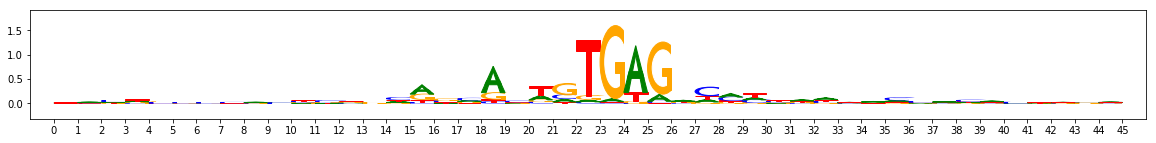

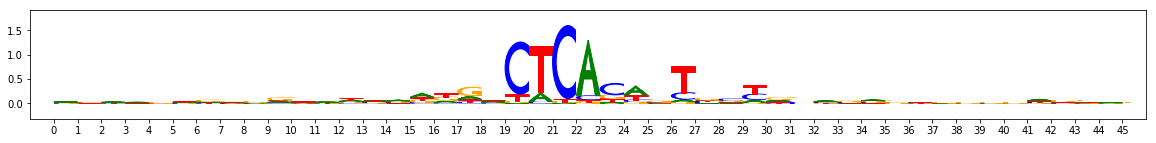

pattern_3
total seqlets: 89
Task 0 hypothetical scores:


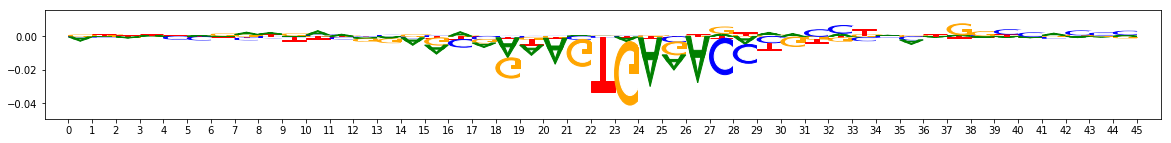

Task 0 actual importance scores:


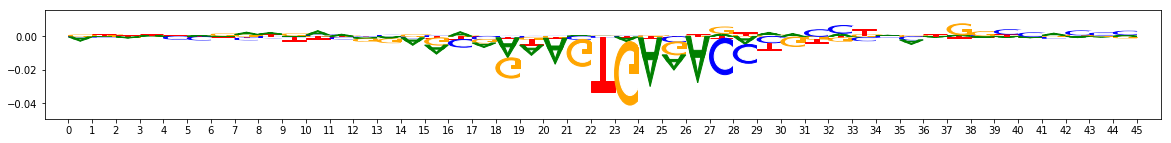

onehot, fwd and rev:


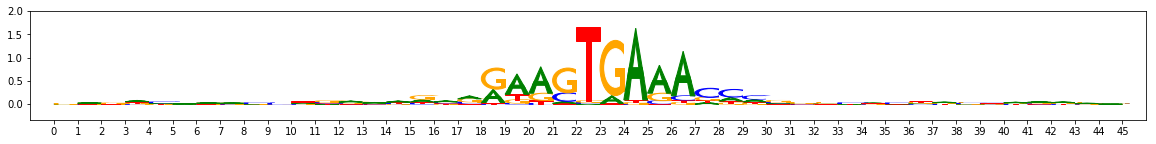

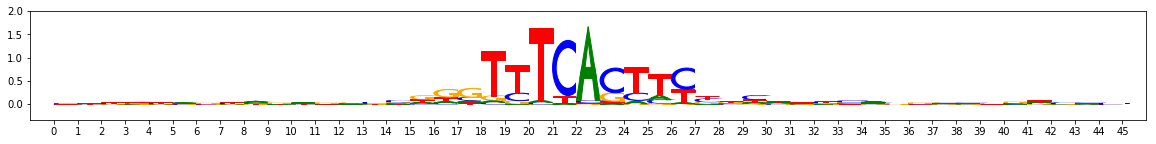

metacluster16
activity pattern: [ 1 -1  0 -1  0]
pattern_0
total seqlets: 483
Task 0 hypothetical scores:


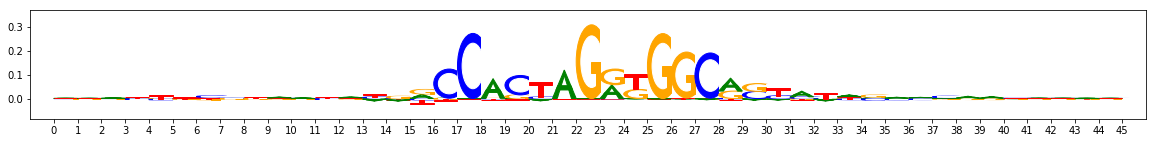

Task 0 actual importance scores:


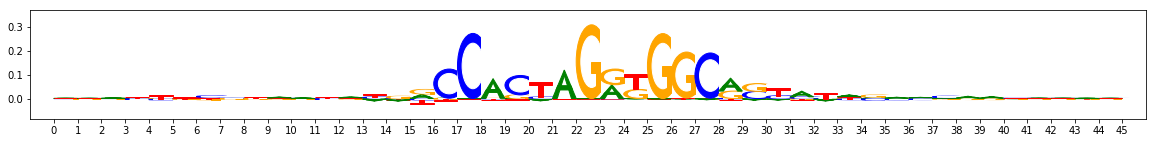

onehot, fwd and rev:


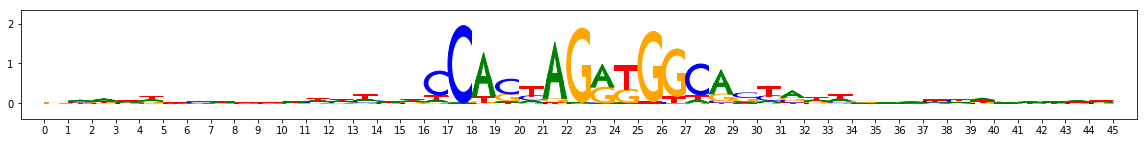

KeyboardInterrupt: 

In [8]:
import h5py

from collections import Counter
from modisco.visualization import viz_sequence
reload(viz_sequence)
from matplotlib import pyplot as plt

import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.aggregator
reload(modisco.aggregator)

hdf5_results = h5py.File("results.hdf5")

metacluster_names = list(hdf5_results["metaclustering_results"]["all_metacluster_names"][:])

for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = (list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:]))
    for pattern_name in all_pattern_names:
        print(pattern_name)
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        background = np.array([0.27, 0.23, 0.23, 0.27])
        print("Task 0 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"])
        print("Task 0 actual importance scores:")
        viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"])
        print("onehot, fwd and rev:")
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                        background=background)) 
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
                                                        background=background)) 
        
hdf5_results.close()